# Exploratory Data Analysis for Cleaning=

Now that we have our main dataset. Let's start to explore the data. This will help us narrow down what we need to clean up, whether there any outliers, and general trends that we could be looking for.

In [2]:
#Start by importing drive from google.colab
from google.colab import drive
import os

#Mount the drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#Students Google Drive Path
toms_path = '/content/drive/MyDrive/Colab Notebooks/593 - Milestone I/593 - Insider Trading Milestone I Project'
kirts_path = None
ramis_path = None

#Navigate to the right working directory and confirm our current working drive
os.chdir(toms_path)
#os.chdir(kirts_path)
#os.chdir(ramis_path)
print(os.getcwd())

/content/drive/MyDrive/Colab Notebooks/593 - Milestone I/593 - Insider Trading Milestone I Project


In [4]:
#Data import
import numpy as np
import pandas as pd
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import time
from datetime import timedelta, date, datetime

In [5]:
#Start by taking a quick look at the files in our directory so we can pull the right one
print(os.listdir())

['insider_transactions_readme[1].pdf', 'parse_form4.py', 'colab_requirements.txt', 'all_common_stock_purchases (6).csv', 'all_common_stock_purchases (6).gsheet', 'Mounting_Notebook_Importing_Form4.ipynb', 'Insider transaction data sets', 'Meeting Summaries', 'Insiders_multi_zip.ipynb', 'Insider Trading Proposal.docx', 'all_common_stock_purchases 2006 to 4Q24.csv', 'sec_insider_zips', 'Insiders_zip_data_processing.ipynb', 'stock_purchases_by_insider.csv', 'download_sec_zips.ipynb', 'common_stock_purchases_with_price_data.csv', 'stock_purchases_enhanced_with_company_info.csv', 'SPY_etf_benchmark_data.ipynb', 'yahoo_finance_price_data.ipynb', 'enhanced_common_stock_purchases_with_spy_data.csv', 'Market_Cap_Sector_Industry_Classification.ipynb', "Insider Trading: Do Corporate Insiders Know Something We Don't?.docx", 'full_csv_with_clean_titles.csv', 'Thomas_EDA.ipynb']


In [6]:
#Read in the .csv file
cs_df = pd.read_csv('enhanced_common_stock_purchases_with_spy_data.csv')
print(f"Let's take a look at the size of our dataframe: {cs_df.shape}\n")
#print(cs_df.head())

#Let's take a look at the number of missing values in the file, I am going to split them into three calls so it's not truncated for formatting
missing_counts = cs_df.iloc[:,:20].isna().sum()
print(missing_counts)
missing_counts = cs_df.iloc[:,20:40].isna().sum()
print(missing_counts)
missing_counts = cs_df.iloc[:,40:].isna().sum()
print(missing_counts)

Let's take a look at the size of our dataframe: (122067, 64)

Insider Name                 0
Insider Title                0
Insider Role                 0
Issuer                       0
Ticker                       0
CIK Code                     0
Period of Report             0
Transaction Date             0
Security                     0
Transaction Code             0
Ownership Type               0
ACCESSION_NUMBER             0
shares                       0
price_per_share              0
shares_after                44
total_capital                0
average_price_per_share    539
price_-1month                0
trend_-1month                0
trend_transactiondate        0
dtype: int64
price_1month               4
trend_1month               4
price_2month             208
trend_2month             208
price_3month             828
trend_3month             828
price_4month            1132
trend_4month            1132
price_5month            1483
trend_5month            1483
price_6month   

The first thing we want to do is look for outliers or data that may not be accurate. The first thing that I notice is that there is a bunch of missing 'average price per shares'. Let's take a look at why and see if these need to be changed or removed.

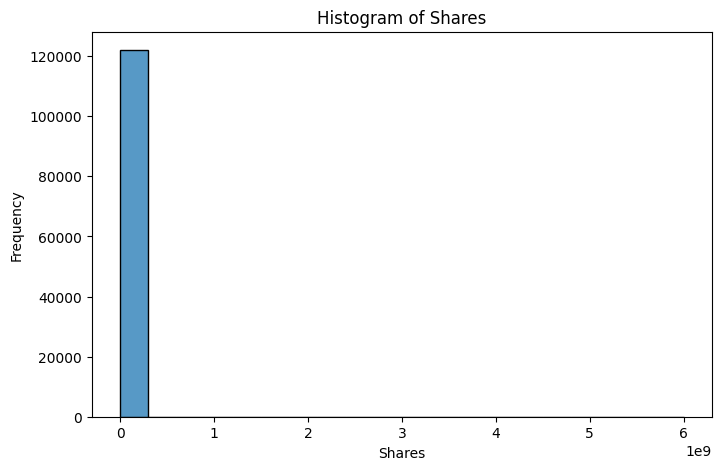

In [7]:
plt.figure(figsize = (8,5))
sns.histplot(data=cs_df, x='shares',bins=20)
plt.xlabel('Shares')
plt.ylabel('Frequency')
plt.title('Histogram of Shares')
plt.show()

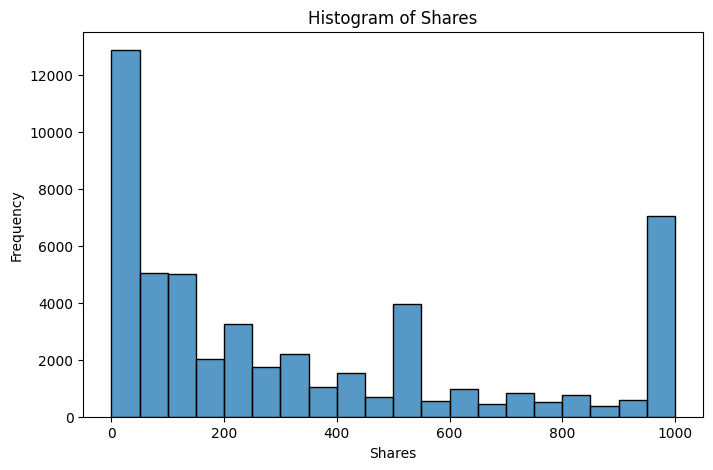

In [8]:
plt.figure(figsize=(8,5))
sns.histplot(data= cs_df, x = 'shares', bins=20, binrange=(0,1000))
plt.xlabel('Shares')
plt.ylabel('Frequency')
plt.title('Histogram of Shares')
plt.show()

In [9]:

temp_df = cs_df[cs_df['average_price_per_share'].isna()]
print(temp_df.iloc[:,:15].head())
#Looks like the shares are 0.0, leading to missing 'average_price_per_share' let's make sure we aren't missing any hidden values somewhere
print(f"\nHere is a list of unique values in 'shares' {temp_df['shares'].unique()}\n")
#They are all 0.0 so let's drop all of those
cs_df = cs_df[~cs_df['average_price_per_share'].isna()]
missing_counts = cs_df.iloc[:,:20].isna().sum()
print(missing_counts)

             Insider Name             Insider Title Insider Role  \
1490  ALLENBAUGH LAUREL G            Vice President      Officer   
3787     AUGUR HARRISON E                   Missing     Director   
6397        BARBAS PAUL M  Executive Vice President      Officer   
6398        BARBAS PAUL M  Executive Vice President      Officer   
8357      BAYARD EUGENE H                   Missing     Director   

                                 Issuer Ticker  CIK Code Period of Report  \
1490  FIRST MID ILLINOIS BANCSHARES INC   FMBH    700565        16-Dec-08   
3787                    PURE CYCLE CORP   PCYO    276720        25-Jul-07   
6397          CHESAPEAKE UTILITIES CORP    CPK     19745        31-Dec-05   
6398          CHESAPEAKE UTILITIES CORP    CPK     19745        31-Dec-05   
8357          CHESAPEAKE UTILITIES CORP    CPK     19745        31-Dec-08   

     Transaction Date      Security Transaction Code Ownership Type  \
1490        29-Aug-08  Common Stock                P     

Okay, that cleaned up a bunch of data that we can't just impute. I think the next big issue will be the dates, so let's get some information about that. Let's start with the min date and max date to look and see if there were any outliers.

In [10]:
min_date = pd.to_datetime(cs_df['Transaction Date'], format = '%d-%b-%y').min()
max_date = pd.to_datetime(cs_df['Transaction Date'], format = '%d-%b-%y').max()
print(f"The min date is {min_date}")
print(f"The max date is {max_date}")

The min date is 1993-05-19 00:00:00
The max date is 2027-07-27 00:00:00


Okay, these are both way off. It may be easier to inspect these visually. Let's see if it would be a good idea to limit these transactions to between 01-01-2006 and 03-31-2025 (End of Q1).

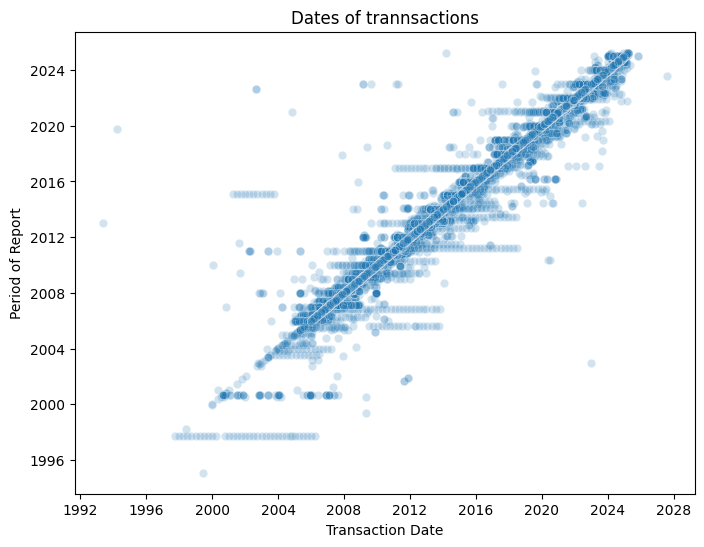

In [11]:
cs_df['Transaction Date'] = pd.to_datetime(cs_df['Transaction Date'],format='%d-%b-%y')
cs_df['Period of Report'] = pd.to_datetime(cs_df['Period of Report'],format='%d-%b-%y')
plt.figure(figsize=(8,6))
sns.scatterplot(data = cs_df, x = 'Transaction Date', y = 'Period of Report', alpha =0.2)
plt.xlabel('Transaction Date')
plt.ylabel('Period of Report')
plt.title('Dates of trannsactions')
plt.show()

In [12]:
filtered_date = cs_df[(pd.to_datetime(cs_df['Transaction Date'], format = '%d-%b-%y') >= pd.to_datetime('01-01-2006')) &((pd.to_datetime(cs_df['Transaction Date'], format = '%d-%b-%y') <= pd.to_datetime('03-31-2025')))]
filtered_date = filtered_date[(pd.to_datetime(filtered_date['Period of Report'], format = '%d-%b-%y') >= pd.to_datetime('01-01-2006')) &((pd.to_datetime(filtered_date['Period of Report'], format = '%d-%b-%y') <= pd.to_datetime('03-31-2025')))]

filtered_date.shape

(120654, 64)

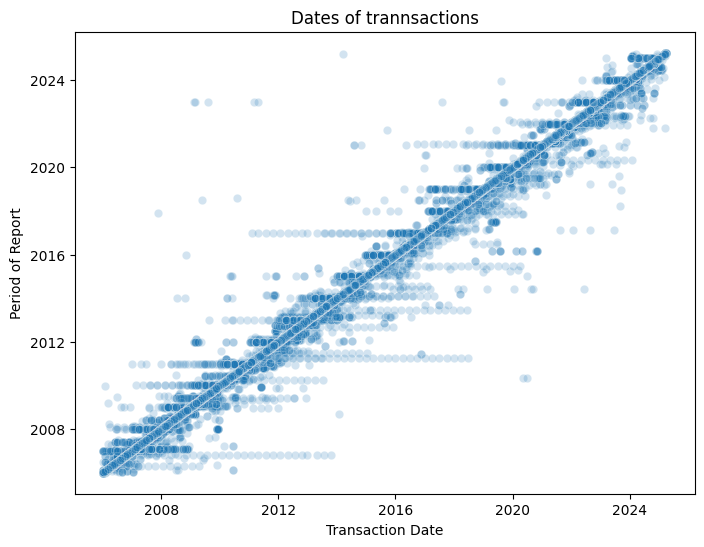

In [13]:
plt.figure(figsize=(8,6))
sns.scatterplot(data = filtered_date, x = 'Transaction Date', y = 'Period of Report', alpha =0.2)
plt.xlabel('Transaction Date')
plt.ylabel('Period of Report')
plt.title('Dates of trannsactions')
plt.show()

That looks much better. I think the next interesting thing to look at would be the average price on the transaction date and the average price paid for the transaction date.

In [14]:
filtered_date['avgprice_transdate'] = np.round((filtered_date['transactiondate_high'] + filtered_date['transactiondate_low'])/2,2)
min_price_per_share = filtered_date['average_price_per_share'].min()
max_price_per_share = filtered_date['average_price_per_share'].max()
print(f"Min price: {min_price_per_share}; Max price: {max_price_per_share}")

Min price: 0.0; Max price: 250000000.0


Okay, the first thing we need to do is drop all transactions where the average price per share is less than $5 because penny stocks are usually too volatile so we won't include them in our analysis.

In [15]:
filtered_date = filtered_date[filtered_date['average_price_per_share']>=5.0]
min_price_per_share = filtered_date['average_price_per_share'].min()
max_price_per_share = filtered_date['average_price_per_share'].max()
print(f"Min price: {min_price_per_share}; Max price: {max_price_per_share}")

Min price: 5.0; Max price: 250000000.0


Now, we need to address the higher end of the price data. It seems as though we have a few prices that are just way too high, in the order of hundereds of millions per share. We can easily catch these by looking at any stock price that is over $100,000 per share. First, let's take a look at the prices visually.

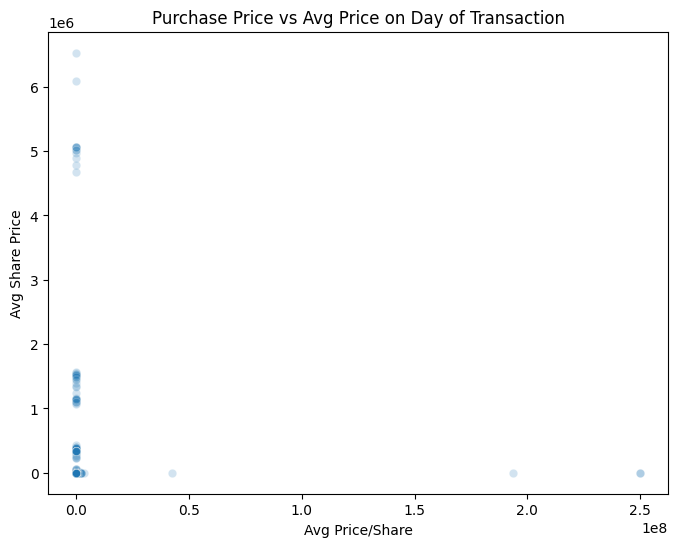

In [16]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=filtered_date, x = 'average_price_per_share', y = 'avgprice_transdate', alpha =0.2)
plt.xlabel('Avg Price/Share')
plt.ylabel('Avg Share Price')
plt.title('Purchase Price vs Avg Price on Day of Transaction')
plt.show()

Alright, this scatter plot is pretty striking. There is a lot of density around 0.0,0.0 which is to be expected when we have log scales on both axis. Clearly, it looks like some of these stock prices are wrong, as I doubt anyone is paying on the order of 250000000 for 1 share. Let's find the difference between these values and look at it on a histogram.

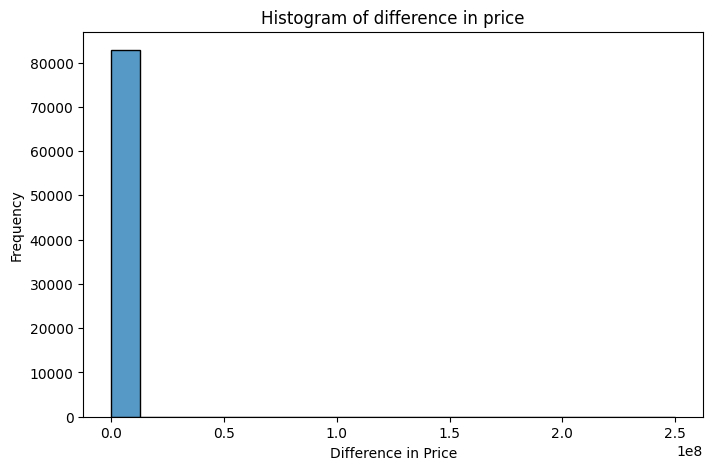

In [17]:
filtered_date['diff_purchase_price'] = (filtered_date['average_price_per_share']-filtered_date['avgprice_transdate']).abs()
plt.figure(figsize=(8,5))
sns.histplot(data = filtered_date, x = 'diff_purchase_price',bins=20)
plt.xlabel('Difference in Price')
plt.ylabel('Frequency')
plt.title('Histogram of difference in price')
plt.show()


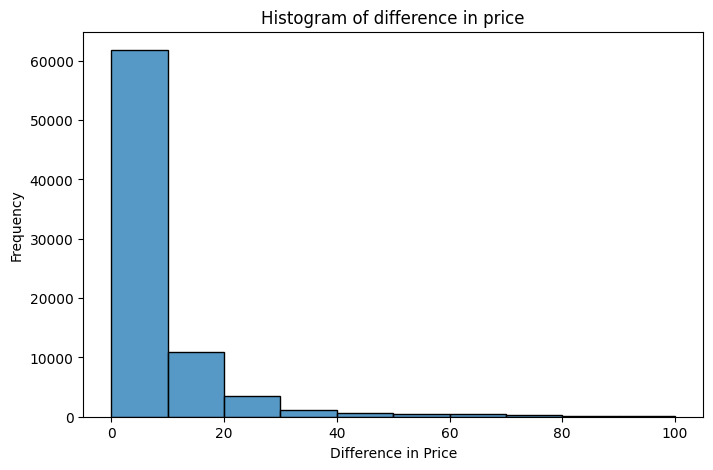

In [18]:
plt.figure(figsize = (8,5))
sns.histplot(data=filtered_date, x='diff_purchase_price',bins=10,binrange=(0,100))
plt.xlabel('Difference in Price')
plt.ylabel('Frequency')
plt.title('Histogram of difference in price')
plt.show()

So, it appears the vast majority (just over 60,000 transactions) fall within $10 of the average price on that date.

In [19]:
 filtered_date[filtered_date['average_price_per_share']==250000000].iloc[:,:15]

,Insider Name,Insider Title,Insider Role,Issuer,Ticker,CIK Code,Period of Report,Transaction Date,Security,Transaction Code,Ownership Type,ACCESSION_NUMBER,shares,price_per_share,shares_after
93000,ROSS WILBUR L JR,Missing,Tenpercentowner,ASSURED GUARANTY LTD,AGO,1273813,2008-02-28,2008-04-08,Common Stock,P,I,0001181431-08-024363,10651896.0,250000000.0,12166396.0
93001,ROSS WILBUR L JR,Missing,Tenpercentowner,ASSURED GUARANTY LTD,AGO,1273813,2008-02-28,2008-04-08,Common Stock,P,I,0001181431-08-030008,10651896.0,250000000.0,12166396.0


The cost of this stock is clearly wrong, let's see if this was an issue with my aggregation or if it was an issue in the original Form4 records. We will pull in our original dataset for comparison.

In [20]:
#Read in the .csv file
orig_df = pd.read_csv('all_common_stock_purchases 2006 to 4Q24.csv')
print(f"Let's take a look at the size of our dataframe: {orig_df.shape}\n")
#print(cs_df.head())

ago_df = orig_df[orig_df['Ticker']=='AGO']
ago_df.shape
ago_df.iloc[:,7:13]

Let's take a look at the size of our dataframe: (463300, 15)



,Transaction Date,Security,Transaction Code,Shares,Price per Share,Shares After
22209,9-Aug-06,Common Stock,P,5000.0,2.489000e+01,12795.26
130010,8-Apr-08,Common Stock,P,10651896.0,2.500000e+08,12166396.00
133833,8-Apr-08,Common Stock,P,10651896.0,2.500000e+08,12166396.00
174765,24-Jun-09,Common Stock,P,3850000.0,4.235000e+07,16023984.00
228059,25-Aug-11,Common Stock,P,6690.0,1.195000e+01,17371186.00
228372,22-Aug-11,Common Stock,P,50000.0,1.133000e+01,16961996.00
228373,24-Aug-11,Common Stock,P,80000.0,1.188000e+01,17364496.00
228374,23-Aug-11,Common Stock,P,322500.0,1.161000e+01,17284496.00
228935,19-Aug-11,Common Stock,P,120000.0,1.153000e+01,16911996.00
228936,18-Aug-11,Common Stock,P,256000.0,1.160000e+01,16791996.00


So unfortunately, it looks like these are inaccurate reports of price per share it was actually around $25 a share, not 250000000. In Jun of 2009, the stock was still in the high teens low 20's so I have no idea where the 4.23e8 came from. It is likely that our future analysis will remove these but we can just remove them now based on their index.


In [21]:
filtered_date = filtered_date.drop(index = [93000,93001])
min_price_per_share = filtered_date['average_price_per_share'].min()
max_price_per_share = filtered_date['average_price_per_share'].max()
print(f"Min price: {min_price_per_share}; Max price: {max_price_per_share}")

Min price: 5.0; Max price: 193537611.0


Let's take a look at all of the stocks that have over $100,000 average price per share and after that we can narrow down the stocks that have a significant difference between the average price on the date of transaction and the average price per share.

In [22]:
high_price_df = filtered_date[filtered_date['average_price_per_share']>100000]
indexes = list(high_price_df.index)
print(high_price_df.shape)
high_price_df[['Ticker','Transaction Date','average_price_per_share','avgprice_transdate','diff_purchase_price']].head()


(32, 66)


,Ticker,Transaction Date,average_price_per_share,avgprice_transdate,diff_purchase_price
3819,INVA,2010-04-30,143000.0,12.70,142987.30
6984,NXPL,2022-12-14,1899999.5,1.44,1899998.06
13073,PEFF,2006-11-30,300000.0,4.05,299995.95
13074,PEFF,2006-11-30,300000.0,4.05,299995.95
21066,NOEC,2010-09-28,938496.0,0.91,938495.09


A quick look at these prices on the date of transaction versus the average price per share clearly shows abnormal date. Let's grab these indexes and remove them from our dataframe.

In [23]:
filtered_date = filtered_date.drop(index = indexes)
min_price_per_share = filtered_date['average_price_per_share'].min()
max_price_per_share = filtered_date['average_price_per_share'].max()
print(f"Min price: {min_price_per_share}; Max price: {max_price_per_share}")
filtered_date.shape

Min price: 5.0; Max price: 95593.41130604288


(82781, 66)

There are two ways we can now address price inaccuracies on the transaction date. One is looking at whether the transaction price falls within the high and low of the price of the stock on the transaction date, the other is to filter the dataset with transactions that fall within 5% of the average trade price for the date of the transaction. The benefit to the later is that it may catch transaction dates that are only off by a day or two where as the former will be specific only to those that likely occured on the reproted transaction date. The former will likely lead to more accurate conclusions, so we will probably move forward with this.


In [24]:
orig_len = (filtered_date.shape[0])
print(filtered_date.shape)
high_low_df = filtered_date[(filtered_date['average_price_per_share'] <= filtered_date['transactiondate_high'])&(filtered_date['average_price_per_share'] >= filtered_date['transactiondate_low'])].copy()
new_len = (high_low_df.shape[0])
print(high_low_df.shape)
print(f"There are only {np.round(new_len/orig_len*100,1)}% of transactions that likely occured on the actual reported transaction date")

(82781, 66)
(20057, 66)
There are only 24.2% of transactions that likely occured on the actual reported transaction date


Let's see how many likely occured 'around the date of transaction' by looking at any stocks that have an avg_price_per_share greater than $100 of the avg price on the transaction date. (This is likely a gross over estimation for low cost stocks).

In [25]:
diff_price_df = filtered_date[filtered_date['diff_purchase_price']>100].copy()
diff_price_df.shape

(3521, 66)

Okay, there is over 3521 records with greater than 100 difference in price. $100 different in a stock that is $2/share versus one that is $1000 per share is a big difference. So let's normalize this against it's avg price on the transaction date to see the percent different which will likely be more accurate.

In [26]:
diff_price_df['normalized_diff'] = diff_price_df['diff_purchase_price']/diff_price_df['avgprice_transdate'] * 100
#lets look for differences greater than 25%
new_diff_df = diff_price_df[diff_price_df['normalized_diff']>50]
new_diff_df.shape

(3518, 67)

Okay, it looks like nearly all in this smaller dataframe are more than 25% different then the average price on the date of the transaction. 99.9% of them are even greater than 50%. I think it is safe to assume that we should remove all of these transactions as well. That also makes me wonder how many are more than certain percentages in our main dataframe?

In [27]:
filtered_date['normalized_diff'] = filtered_date['diff_purchase_price']/filtered_date['avgprice_transdate'] * 100
#lets look for differences greater than 25%
big_diff_df = filtered_date[filtered_date['normalized_diff']>25]
length_filt = big_diff_df.shape[0]
length_nofilt=filtered_date.shape[0]
print(length_nofilt, length_filt)
print(f"{np.round(length_filt/length_nofilt * 100,2)}% of records have more than 25% difference between the avg stock price on the date of the transaction and the average buy price provided")

82781 38765
46.83% of records have more than 25% difference between the avg stock price on the date of the transaction and the average buy price provided


So nearly 55,000 records have more than a 25% difference between avg stock price and price of the buy on the transaction date. That's pretty significant.

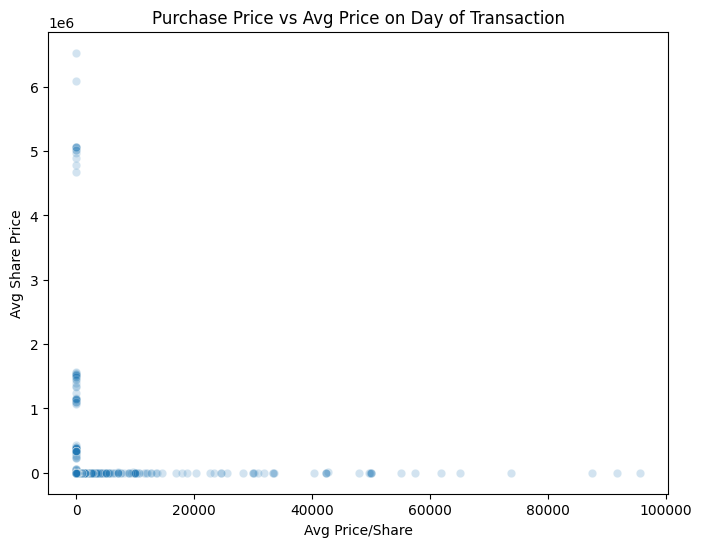

In [28]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=filtered_date, x = 'average_price_per_share', y = 'avgprice_transdate', alpha =0.2)
plt.xlabel('Avg Price/Share')
plt.ylabel('Avg Share Price')
plt.title('Purchase Price vs Avg Price on Day of Transaction')
plt.show()

Okay, this will dramatically reduce our dataset but let's take a look at what we might have for any stocks where its actually less than 5%.

In [29]:
low_diff_df = filtered_date[filtered_date['normalized_diff']<=5]
print(low_diff_df.shape)
print(len(low_diff_df['Insider Title'].unique()))
print(low_diff_df['Insider Title'].value_counts()[:10])

(24486, 67)
1136
Insider Title
Missing                     16106
Chief Executive Officer      1068
President and CEO             722
Chief Financial Officer       412
President & CEO               384
CEO                           257
Chairman and CEO              245
Executive Vice President      175
President and COO             169
President                     143
Name: count, dtype: int64


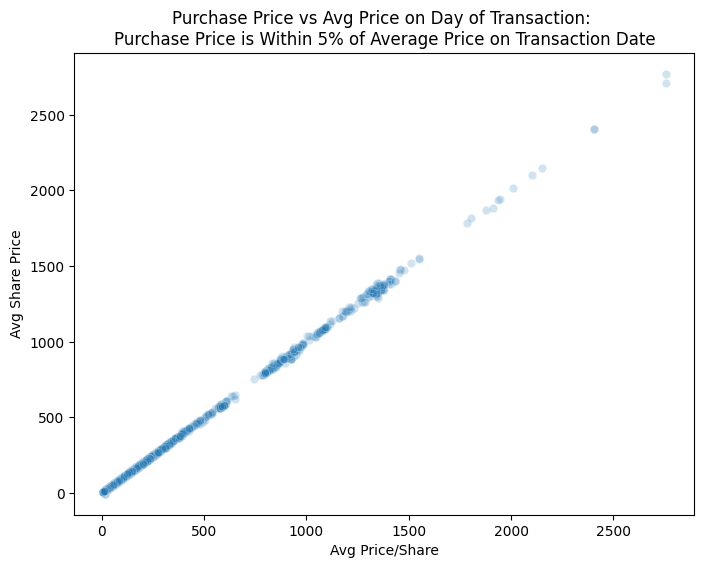

In [30]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=low_diff_df, x = 'average_price_per_share', y = 'avgprice_transdate', alpha =0.2)
plt.xlabel('Avg Price/Share')
plt.ylabel('Avg Share Price')
plt.title('Purchase Price vs Avg Price on Day of Transaction: \nPurchase Price is Within 5% of Average Price on Transaction Date')
plt.show()

Okay, this did dramatically reduce our data set but we still have a few hundered of each position which may be enough for an analysis. At least it is more likely to be an accurate analysis. I do still think we should use only the data that fell with in the high and low of the stock for that date. So lets see the counts for that dataframe.

In [31]:
print(high_low_df.shape)
print(len(high_low_df['Insider Title'].unique()))
print(high_low_df['Insider Title'].value_counts()[:10])

(20057, 66)
964
Insider Title
Missing                     13197
Chief Executive Officer       996
President and CEO             637
Chief Financial Officer       354
President & CEO               311
CEO                           236
Chairman and CEO              187
President and COO             166
Executive Vice President      152
See Remarks                   128
Name: count, dtype: int64


If we were to use only the data that was within the high and low of the transaction date we would have. The following graph.

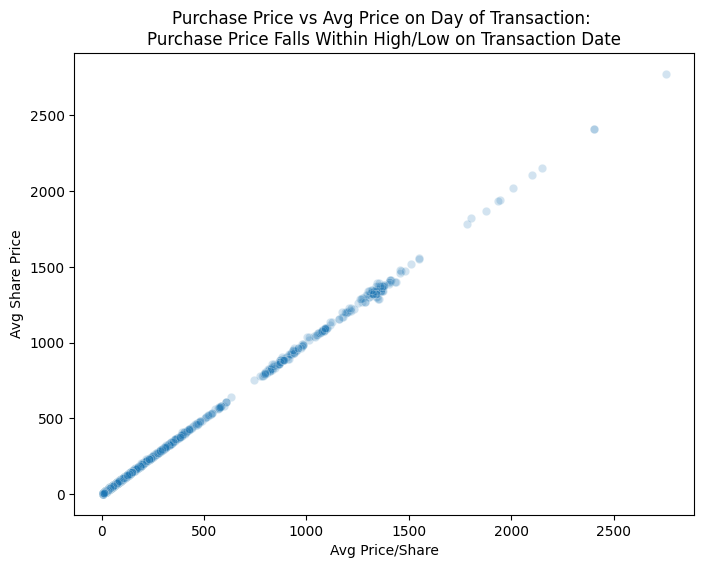

In [32]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=high_low_df, x = 'average_price_per_share', y = 'avgprice_transdate', alpha =0.2)
plt.xlabel('Avg Price/Share')
plt.ylabel('Avg Share Price')
plt.title('Purchase Price vs Avg Price on Day of Transaction: \nPurchase Price Falls Within High/Low on Transaction Date')
plt.show()

I think the next natural step is to try and clear up the Insider Role and titles. Let's first look and see how many of the 'missing titles' have director in the 'Insider Role' section. Let's start by working with the 'Insider Role' Column as there are much less data points and options there. It will work as a proof of concept for the Insider title column.

In [33]:
missing_title = high_low_df[high_low_df['Insider Title']=='Missing']
print(missing_title.shape)
#Let's now look at the unique roles we have in here.
roles = missing_title['Insider Role'].unique()
print(f"There are {len(roles)} different roles that we need to work with")
roles

(13197, 66)
There are 9 different roles that we need to work with


array(['Director', 'Tenpercentowner', 'Directorother',
       'Director,Tenpercentowner', 'Tenpercentownerother',
       'Director,Other', 'Director,Tenpercentowner,Other',
       'Director,Tenpercentownerother', 'Tenpercentowner,Other'],
      dtype=object)

Okay, the first thing we will need to do is split the information (most often by a comma) so we will address that first. We need to write a function that will split, rename, then rejoin. Then we can use dummies to easily filter the dataframes.

In [34]:
#Let's create a map for the roles to be replaced
role_mapping = {'Director':'Director',
                'Tenpercentowner':'10%owner',
                'Tenpercentownerother': '10%owner,Other',
                'Other':'Other',
                'Directorother':'Director,Other'}
mapped_role = missing_title.copy()
#Let's create a function that splits them changes them and rejoins them
def mapping_roles(roles):
    role = [r.strip() for r in roles.split(',')]
    map_roles = [role_mapping.get(r,r) for r in role]
    return ','.join(map_roles)

mapped_role['Mapped Roles'] = mapped_role['Insider Role'].apply(mapping_roles)
roles = mapped_role['Mapped Roles'].unique()
print(f"The new number of roles is {len(roles)}")
roles

The new number of roles is 6


array(['Director', '10%owner', 'Director,Other', 'Director,10%owner',
       '10%owner,Other', 'Director,10%owner,Other'], dtype=object)

Okay, now that we have cleaned this up, we can one hot encode this by using the get_dummies method.

In [35]:
role_dummies = mapped_role['Mapped Roles'].str.get_dummies(sep=',')
full_df = pd.concat([mapped_role,role_dummies],axis=1)
full_df.head()

,Insider Name,Insider Title,Insider Role,Issuer,Ticker,CIK Code,Period of Report,Transaction Date,Security,Transaction Code,...,transactiondate_high,transactiondate_low,reportdate_high,reportdate_low,avgprice_transdate,diff_purchase_price,Mapped Roles,10%owner,Director,Other
67,ABERCROMBIE GEORGE B,Missing,Director,BIOCRYST PHARMACEUTICALS INC,BCRX,882796,2013-11-12,2013-11-12,Common Stock,P,...,6.33,5.60,6.33,5.60,5.96,0.230,Director,0,1,0
75,ABERNATHY ROBERT E,Missing,Director,HAEMONETICS CORP,HAE,313143,2020-08-11,2020-08-11,Common Stock,P,...,81.15,78.99,81.15,78.99,80.07,0.860,Director,0,1,0
142,ABRAHAM CHAD R,Missing,Director,COLUMBUS MCKINNON CORP,CMCO,1005229,2025-03-03,2025-03-03,Common Stock,P,...,17.44,15.89,17.44,15.89,16.66,0.615,Director,0,1,0
154,ABRAHAMSON JAMES A,Missing,Director,"GeoEye, Inc.",GEOY,1040570,2011-12-01,2011-12-01,common stock,P,...,19.29,18.33,19.29,18.33,18.81,0.410,Director,0,1,0
162,ABRAMS DAVID C,Missing,Tenpercentowner,ASBURY AUTOMOTIVE GROUP INC,ABG,1144980,2020-03-18,2020-03-18,Common Stock,P,...,44.96,41.41,44.96,41.41,43.18,0.090,10%owner,1,0,0


Now, we can look at whoever we want based on the roles that they have. We can look at the average return of Directors by filtering the dataframe and then using a scatter plot.

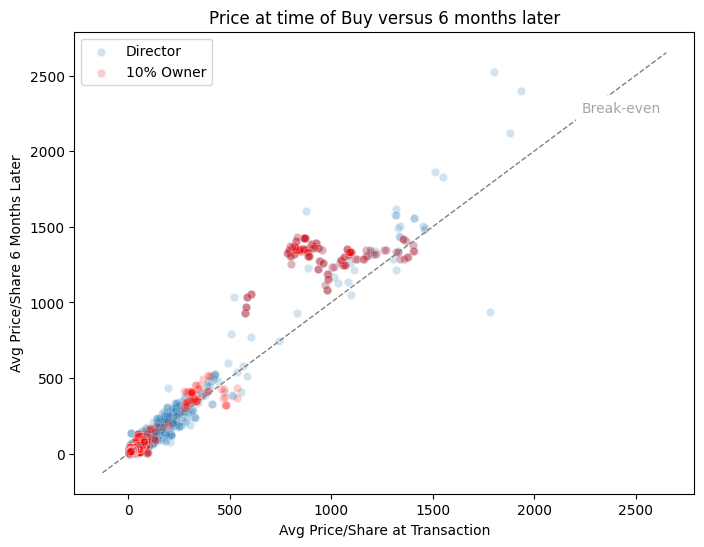

In [36]:
#Let's Look at Directors vs. 10% Owners
dir_df = full_df[full_df['Director']==1]
own_df = full_df[full_df['10%owner']==1]
plt.figure(figsize=(8,6))
sns.scatterplot(data=dir_df, x = 'average_price_per_share', y = 'price_6month', alpha =0.2,label='Director')
sns.scatterplot(data=own_df, x = 'average_price_per_share',y='price_6month',alpha=0.2,color='red',label='10% Owner')

#Let's put in a 45degree line to show break even
ax = plt.gca()
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),
    max(ax.get_xlim()[1], ax.get_ylim()[1])
]
plt.plot(lims, lims, linestyle='--', color='gray', linewidth=1)

#Lets give it an annotation
x_text = lims[0] + 0.85 * (lims[1] - lims[0])
y_text = x_text
plt.text(
    x_text, y_text,
    'Break-even',
    ha='left', va='bottom',
    fontsize=10,
    color='gray',
    backgroundcolor='white',
    alpha=0.7
)

plt.xlabel('Avg Price/Share at Transaction')
plt.ylabel('Avg Price/Share 6 Months Later')
plt.title('Price at time of Buy versus 6 months later')
plt.show()

We now need to apply this to our large dataframe as this was only a small proof of concept.

In [37]:
#Let's now look at the unique roles we have in here.
roles = high_low_df['Insider Role'].unique()
print(f"There are {len(roles)} different roles that we need to work with")
roles

There are 18 different roles that we need to work with


array(['Officer', 'Director', 'Tenpercentowner', 'Director,Officer',
       'Directorother', 'Director,Officer,Tenpercentowner',
       'Director,Tenpercentowner', 'Tenpercentownerother',
       'Director,Other', 'Director,Tenpercentowner,Other',
       'Director,Officerother', 'Officerother',
       'Director,Tenpercentownerother',
       'Director,Officer,Tenpercentowner,Other',
       'Director,Officer,Tenpercentownerother', 'Officer,Tenpercentowner',
       'Tenpercentowner,Other', 'Director,Officer,Other'], dtype=object)

In [38]:
print(f"Shape of our df originally: {high_low_df.shape}")
role_mapped = high_low_df.copy()
role_mapping = {'Director':'Director',
                'Tenpercentowner':'10%owner',
                'Officer':'Officer',
                'Other':'Other',
                'Director,Officer,Tenpercentownerother':'Director,Officer,10%owner,Other',
                'Director,Officerother':'Director,Officer,Other',
                'Director,Tenpercentownerother':'Director,10%owner,Other',
                'Tenpercentownerother': '10%owner,Other',
                'Officerother':'Officer,Other',
                'Directorother':'Director,Other'}
#Let's create a function that splits them changes them and rejoins them
def mapping_roles(roles):
    role = [r.strip() for r in roles.split(',')]
    map_roles = [role_mapping.get(r,r) for r in role]
    return ','.join(map_roles)

role_mapped['Mapped Roles'] = role_mapped['Insider Role'].apply(mapping_roles)
roles = role_mapped['Mapped Roles'].unique()
print(f"Now the shape is {role_mapped.shape}")
print(f"The new number of roles is {len(roles)}")
roles

Shape of our df originally: (20057, 66)
Now the shape is (20057, 67)
The new number of roles is 13


array(['Officer', 'Director', '10%owner', 'Director,Officer',
       'Director,Other', 'Director,Officer,10%owner', 'Director,10%owner',
       '10%owner,Other', 'Director,10%owner,Other',
       'Director,Officer,Other', 'Officer,Other',
       'Director,Officer,10%owner,Other', 'Officer,10%owner'],
      dtype=object)

In [39]:
#Excellent, let's one hot encode
role_dummies = role_mapped['Mapped Roles'].str.get_dummies(sep=',')
role_dummies = pd.concat([role_mapped,role_dummies],axis=1)
print(role_dummies.shape)
role_dummies.head()

(20057, 71)


,Insider Name,Insider Title,Insider Role,Issuer,Ticker,CIK Code,Period of Report,Transaction Date,Security,Transaction Code,...,transactiondate_low,reportdate_high,reportdate_low,avgprice_transdate,diff_purchase_price,Mapped Roles,10%owner,Director,Officer,Other
64,ABENDSCHEIN ROBERT D.,See Remarks,Officer,TALOS ENERGY INC.,TALO,1724965,2020-08-11,2020-08-11,Common Stock,P,...,7.98,8.68,7.98,8.33,0.01,Officer,0,0,1,0
65,ABENDSCHEIN ROBERT D.,See Remarks,Officer,TALOS ENERGY INC.,TALO,1724965,2021-11-19,2021-11-19,Common Stock,P,...,9.47,9.97,9.47,9.72,0.02,Officer,0,0,1,0
66,ABENDSCHEIN ROBERT D.,See Remarks,Officer,TALOS ENERGY INC.,TALO,1724965,2021-11-19,2021-11-19,Common Stock,P,...,9.47,9.97,9.47,9.72,0.02,Officer,0,0,1,0
67,ABERCROMBIE GEORGE B,Missing,Director,BIOCRYST PHARMACEUTICALS INC,BCRX,882796,2013-11-12,2013-11-12,Common Stock,P,...,5.60,6.33,5.60,5.96,0.23,Director,0,1,0,0
75,ABERNATHY ROBERT E,Missing,Director,HAEMONETICS CORP,HAE,313143,2020-08-11,2020-08-11,Common Stock,P,...,78.99,81.15,78.99,80.07,0.86,Director,0,1,0,0


# Left off Here... This section is not complete

We have now had the proof of concept for the smaller 'Insider Role' Column. Now we have to deal with the really large 'Insider Title' Column. This is a much larger number of roles that we will have to deal with, so we will use a similar function to the one we used before. This is going to likely take many repetitions in order to get every title that we need to do. So let's start by looking at the value counts and working our way through them.

Let's keep track of any of the accronyms that I am using:  
- CEO: Chief Executive Officer  
- CEOi: Interim Chief Executive Officer
- CEOc: Co-Chief Executive Officer
- CFO: Chief Financial Officer
- CFOi: Interim Chief Financial Officer
- CAO: Chief Accounting Officer
- CDeO: Chief Development Officer
- PAO: Principal Accounting Officer
- CAdO: Chief Administration Officer
- CA: Chief Architect
- CGO: Chief Growth Officer
- CIO: Chief Information Officer
- CInO: Chief Innovation Officer
- CPO: Chief Procurment Officer
- CInvO: Chief Investment Officer
- CHrO: Chief Human Resources Officer
- CCuO: Cheif Customer Officer
- CDO: Chief Digital Officer
- CCoO: Chief Compliance Officer
- CConO: Chief Concept Officer
- CSCO: Chief Supply Chain Officer
- CMeO: Chief Medical Officer
- CMerO: Chief Merchandising Officer
- CMO: Chief Marketing Officer
- CLO: Chief Legal Officer
- CLeO: Chief Lending Officer
- COO: Chief Operating Officer
- COOc: Co-Chief Operating Officer
- CSO: Chief Strategy Officer
- CScO: Chief Scientific Officer
- CCO: Chief Commercial Officer
- CCrO: Chief Credit Officer
- CQO: Chief Quality Offier
- CTO: Chief Technology Officer
- CTaO: Chief Talent Officer
- CRO: Chief Risk Officer
- CReO: Chief Revenue Officer
- CRDO: Chief Research and Development Officer
- CPO: Chief People Officer
- CPrO: Chief Product Officer
- CBO: Chief Business Officer
- CBaO: Chief Banking Officer
- CBrO: Chief Broker Officer
- CIDO: Chief International Development Officer
- EVP: Executive Vice President  
- SVP: Senior Vice President
- SLO: Senior Loan Officer
- F: Founder
- P: President
- Pc: Co-President
- Pf: Former President
- Pi: Interim President
- VP: Vice President
- VPf: Vice President of Finance
- EC: Executive Chairman
- C: Chairman
- VC: Vice Chairman
- DC: Deputy Chairman
- D: Director
- DR: Director of Research
- DT: Director of Technology
- GC: General Counsel
- O: Operations
- S: Corporate Secretary
- T: Treasurer
- FS: Financial Services
- DRRM: Director of Regulatory Risk Management
- HFD: Head of Fund Development
- HAS: Head of Advisor Services
- HSBL: Head of Small Business Lending
- HCL: Head of Commercial Lending
- HRD: Head of Reserach and Development
- HPS: Head of Payment Solutions
- HOI: Head of Investments
- HCB: Head of Commercial Banking
- HRB: Head of Retail Banking
- HCD: Head of Corporate Development
- HMA: Head of Mergers and Aquisitions
- HAI: Head of Affiliate Investments
- HAE: Head of Affiliate Engagement
- SBD: Sales and Buisness Development
- Con: Controller
- GM: General Manager
- HR: Human Resources
- SMD: Senior Managing Director
- PEO: Professional Employer Organization
- PEOi: Interim Professional Employet Orginization
- MD: Managing Director


In [40]:
full_df = role_dummies.copy()
full_df['Insider Title'].value_counts()

replacements = {'Chief Executive Officer':'CEO',
                'CHIEF EXECUTIVE OFFICER':'CEO',
                'Chief Financial Officer':'CFO',
                'CHIEF FINANCIAL OFFICER':'CFO',
                'Chief Accounting Officer':'CAO',
                'Chief Administration Officer':'CAdO',
                'Chief Information Officer':'CIO',
                'Chief Innovation Officer':'CInO',
                'Chief Investment Officer':'CInvO',
                'Chief Medical Officer':'CMeO',
                'Chief Marketing Officer':'CMO',
                'Chief Operating Officer':'COO',
                'Chief Strategy Officer':'CSO',
                'Chief Legal Officer':'CLO',
                'Chief Business Officer':'CBO',
                'Chief Commercial Officer':'CCO',
                'Chief Technology Officer':'CTO',
                'Chief Human Resources Officer':'CHrO',
                'Chief Risk Officer':'CRO',
                'Executive Vice President':'EVP',
                'Senior Vice President':'SVP',
                'SVP OF INFORMATION TECHNOLOGY':'SVP',
                'President':'P',
                'PRESIDENT':'P',
                'Treasurer':'T',
                'Treasurer, Secretary':'T,S',
                'Group Vice President':'VP',
                'Vice President':'VP',
                'Vice President of Finance':'VPf',
                'Corporate Secretary':'S',
                'Director':'D',
                'Operations':'O',
                'Executive Chairman':'EC',
                'EXECUTIVE CHAIRMAN OF BOARD':'EC',
                'Chairman':'C',
                'Chairman of the Board':'C',
                'Vice Chairman':'VC',
                'President and CEO':'CEO,P',
                'President & CEO':'CEO,P',
                'CEO and President':'CEO,P',
                'PRESIDENT AND CEO':'CEO,P',
                'CEO & President':'CEO,P',
                'PRESIDENT & CEO':'CEO,P',
                'President, CEO':'CEO,P',
                'CEO/President':'CEO,P',
                'CEO, President':'CEO,P',
                'Chairman and CEO':'CEO,C',
                'Chairman/CEO':'CEO,C',
                'CEO and Chairman of the Board':'CEO,C',
                'Chairman, CEO':'CEO,C',
                'President and COO':'COO,P',
                'President & COO':'COO,P',
                'President & Treasurer':'P,T',
                'CFO & EVP':'CFO,EVP',
                'CFO and EVP':'CFO,EVP',
                'Exec VP & CFO':'CFO,EVP',
                'EVP and CFO':'CFO,EVP',
                'EVP & CFO':'CFO,EVP',
                'EVP & Chief Financial Officer':'CFO,EVP',
                'EVP, Chief Financial Officer':'CFO,EVP',
                'Executive VP and CFO':'CFO,EVP',
                'EVP, CFO':'CFO,EVP',
                'SVP & Chief Financial Officer':'CFO,SVP',
                'SVP & CFO':'CFO,SVP',
                'Chairman & CEO':'CEO,C',
                'Chairman, President & CEO':'CEO,P,C',
                'COB, CEO, President':'CEO,P,C',
                'Chairman, President and CEO':'CEO,P,C',
                'Chair. of the Board, Pres.,CEO':'CEO,P,C',
                'Chairman, CEO and President': 'CEO,P,C',
                'President, Financial Services': 'P,FS',
                'Executive VP, COO, and CFO':'CFO,COO,EVP',
                'COO, CFO and EVP':'CFO,COO,EVP',
                'Co-Chairman of the Board':'C',
                'President / CEO / Director':'CEO,P,D',
                'Chairman of the Board and CEO':'CEO,C',
                'CEO and Director':'CEO,D',
                'Vice Chairman & CTO':'CTO,VC',
                'Interim CEO':'CEOi',
                'Co-Chief Executive Officer':'CEOc',
                'EVP, DIRECTOR OF REG RISK MNGT':'EVP, DRRM',
                'VP, Head of Fund Development':'VP,HFD',
                'VP, Sales & Bus. Development': 'VP,SBD',
                'CEO, Secretary, Treasurer':'CEO,T,S',
                'Pres. & CEO':'CEO,P',
                'CEO and CIO':'CEO,CIO',
                'SVP and CFO':'CFO,SVP',
                'EVP,Operations':'EVP,O',
                'General Counsel and Secretary':'GC,S',
                'EVP, CFO & Treasurer':'CFO,EVP,T',
                'See remarks':'See Remarks',
                'FOUNDER & CEO':'CEO,F',
                'CFO & Secretary':'CFO,S',
                "Sr. VP, Gen'l Counsel & Sec'y.":'SVP,GC,S',
                "SR EXEC VP OF SPECIAL PROJECTS":'SVP',
                'Vice President, Controller': 'VP,Con',
                'General Counsel & Corp. Sec.': 'GC,S',
                'EVP, COO and CFO':'CFO,COO,EVP',
                'EVP and COO':'COO,EVP',
                'Sr. VP Information Services': 'SVP',
                'Sr. Vice President':'SVP',
                'CEO AND PRESIDENT':'CEO,P',
                'General Counsel':'GC',
                'EVP and CCO':'CCO,EVP',
                'Vice President of Operations':'VP',
                'Executive VP-Administration':'EVP',
                'Vice Chairman/Co CEO/President':'CEOc,P,VC',
                'EVP, Treasurer, Secretary, CFO': 'CFO,T,S,EVP',
                'SVP, CFO AND TREASURER': 'CFO,T,SVP',
                'Exec. VP and CFO': 'CFO,EVP',
                'EVP Human Resources':'EVP',
                'Executive VP & COO': 'COO,EVP',
                'Senior Vice President, CFO':'CFO,SVP',
                'COO & President': 'COO,P',
                'VP & CFO': 'CFO,VP',
                'EVP, CFO and Treasurer':'CFO,T,EVP',
                'Travelzoo GM, Germany':'GM',
                'VP, Human Resources': 'VP,HR',
                'Chief Executive Officer & CTO': 'CEO,CTO',
                'VP Finance and Adminisitration': 'VP',
                'President and C.O.O.':'COO,P',
                'CFO, Treasurer & Secretary': 'CFO,T,S',
                'EVP - HR (CHESI)':'EVP',
                'EVP, Chief Operating Officer':'COO,EVP',
                "EVP, President of Maggiano's":'EVP,P',
                'VP Finance and Administration,':'VP',
                'Exec. Vice President, Europe':'EVP',
                'General Counsel & Secretary':'GC,S',
                'President & CFO':'CFO,P',
                'Executive VP & CFO':'CFO,EVP',
                'VP and Secretary':'VP,S',
                'Sr. VP Finance, CFO':'CFO,SVP',
                'SVP, Chief Financial Officer':'CFO,SVP',
                "SVP, Chief Int'l Dev Ofc":'CIDO,SVP',
                "SVP, CFO & President-SBS":"CFO,P,SVP",
                "Senior VP & CFO": "CFO,SVP",
                'Chairman, Pres. & CEO':'CEO,P,C',
                'President, North America':'P',
                'CFO and Treasurer':'CFO,T',
                'SEVP & Chief Financial Officer':'CFO,SVP',
                'President, COO':'COO,P',
                'SVP & Chief Accounting Officer': 'CAO,SVP',
                'VP Sales & Bus Development': 'VP',
                'EVP & COO':'COO,EVP',
                'CEO,QCRH & CRBT':'CEO,QCRH,CRBT',
                'SVP, General Counsel': 'GC,SVP',
                'EVP, General Counsel': 'GC,EVP',
                'VP Finance & Admin CFO':'CFO,VP',
                'Chief Administrative Officer':'CAdO',
                'SVP, Executive Programs':'SVP',
                'Sr Vice President/Engineering':'SVP',
                'EVP, Chief HR Officer':'CHrO,EVP',
                'Director, President and CEO':'CEO,P,D',
                'President, CEO, COB': 'CEO,P,C',
                'VP, Treasurer, Secretary & CFO':'CFO,T,S,VP',
                'Chairman, QCR Holdings':'C',
                'CEO of Bank Subsidiary':'CEO',
                'Corporate Controller':'Con',
                'EVP, Chief Information Officer':'CIO,EVP',
                'President, CEO, and CIO':'CEO,CIO,P',
                'President,':'P',
                'CAO & General Counsel':'CAO,GC',
                'Pres-Ampac Fine Chemicals LLC':'P',
                'President and CFO': 'CFO,P',
                'Executive VP, CFO & Treasurer':'CFO,T,EVP',
                'Exec VP - Euprope,Asia & CPG':'EVP',
                'President, QCR Holdings':'P',
                'Secretary and General Counsel':'GC,S',
                'VP & Controller':'VP,Con',
                'Chairman of the Board/Co CEO':'CEOc,C',
                'VP Mktg & Strategic Planning':'VP',
                'President, R&D':'P',
                'EVP & GENERAL COUNSEL':'GC,EVP',
                'President, CEO, Chairman':'CEO,P,C',
                'President - CEO':'CEO,P',
                'Exec.V.P. and CFO, QCR Holding':'CFO,EVP',
                'VP- Customer Service':'VP',
                'Sr. VP, General Counsel':'GC,SVP',
                'Senior Vice President and CFO':'CFO,SVP',
                'President, Vista Staffing':'P',
                'President/CEO':'CEO,P',
                'EVP Strategy & Engagement':'EVP',
                'Chairmen':'C',
                'Exec VP, CFO & Treasurer':'CFO,T,EVP',
                'Sr. VP, General Counsel,':'GC,SVP',
                'Executive VP Finance & CFO':'CFO,EVP',
                'VP- Engineering':'VP',
                'V.P. & Senior Loan Officer': 'SLO,VP',
                'EVP, Human Resources':'EVP',
                'SVP Finance & CFO': 'CFO,SVP',
                'VP & Chief Financial Officer':'CFO,VP',
                'Pres., CEO & Chairman of Bd': 'CEO,P,C',
                'President, CEO & Chairman': 'CEO,P,C',
                'Deputy Chairman':'DC',
                'EVP/CFO':'CFO,EVP',
                'Exec VP - Europe, Asia & CPG': 'EVP',
                'Vice President & Controller -':'VP,Con',
                'CEO and Chief Architect': 'CEO,CA',
                'VP, Chief Commercial Officer': 'CCO,VP',
                'Senior VP and CFO':'CFO,SVP',
                'Sr VP & GM Industrial Pro':'SVP',
                'SVP Commercial Sales':'SVP',
                'Executive VP of R&D':'EVP',
                'SVP, Chief Accounting Officer':'CAO,SVP',
                'PFO and PAO':'PFO,PAO',
                'CHAIRMAN OF THE BOARD':'C',
                'Controller':'Con',
                'Senior Vice President, Sales':'SVP',
                'Sr. VP and CFO': 'CFO,SVP',
                'President, Subsidiary':'P',
                'Chief Customer Exper. Officer':'CCuO',
                'CFO and Executive VP':'CFO,EVP',
                'EVP, GC and Head of M&A':'GC,HMA',
                'Interim President & CEO':'CEOi,Pi',
                'Executive VP':'EVP',
                'Chief Legal Officer & VP': 'CLO,VP',
                'Sr. VP, CFO and Treasurer': 'CFO,T,SVP',
                'VP and Chief Financial Officer':'CFO,VP',
                'VP, Corporate Controller':'VP,Con',
                'EVP and Chief Credit Officer':'CCrO,EVP',
                'EVP, CHIEF INFORMATION OFFICER':'CIO,EVP',
                'Pres., Spacelabs Healthcare':'P',
                'Sr VP-Finance and CFO':'CFO,SVP',
                'Group VP, Golf, Grounds & Irr':'VP',
                'VP, Patient Advocacy':'VP',
                'Sr VP and CFO': 'CFO,SVP',
                'Senior Vice President & CIO':'CIO,SVP',
                'SVP OF INFORMATION SYSTEMS':'SVP',
                'VP, Chief Financial Officer': 'CFO,VP',
                'SVP of CommScope, Inc.':'SVP',
                'Chairman / CEO':'CEO,C',
                'Chief Supply Chain Officer':'CSCO',
                'EVP - Chief Financial Officer':'CFO,EVP',
                'EVP-Chief Operating Officer':'COO,EVP',
                'VP of IT Operations': 'VP',
                'Chief Human Resource Officer':'CHrO',
                'Sr VP/Chief Commercial Officer':'CCO,SVP',
                'President, Mattress Fabrics':'P',
                'Chief People Officer':'CPO',
                'EVP Chief Admin Officer':'CAdO,EVP',
                'EVP, GEN COUNSEL & CORP SEC':'GC,S,EVP',
                'Sr. VP of Finance and CFO': 'CFO,SVP',
                'President, Global Pharm. Div.':'P',
                'CFO, Treasurer':'CFO,T',
                'CEO - Oxford Global Resources':'CEO',
                'VP Finance and Controller':'VP,Con',
                'CHIEF INVESTMENT OFFICER':'CInvO',
                'Exec VP & COO':'COO,EVP',
                'SVP - Chief Financial Officer':'CFO,SVP',
                'VP Corp, Mktg & Strategy':'VP',
                'EVP (CHESI)':'EVP',
                'CEO, CFO':'CEO,CFO',
                'VP, Technical Operations':'VP',
                'Exec Chairman and Interim CEO':'CEOi,EC',
                'Pres. & Chief Comm. Officer':'CCO,P',
                'EVP, COO - Land, Legal & Admin':'COO,EVP',
                'SVP, General Counsel & Sec': 'GC,S,SVP',
                'CFO & COO':'CFO,COO',
                'EVP, Chief Legal Officer':'CLO,EVP',
                'VP, Legal & IP':'VP',
                'VP, CFO & Treasurer':'CFO,T,VP',
                'VP & Chief Credit Officer':'CCrO,VP',
                'President, CEO and Director':'CEO,P,D',
                'VP and Corporate Controller':'VP,Con',
                'Executive Vice President -Asia':'EVP',
                'Vice-President':'VP',
                'President & C.E.O.':'CEO,P',
                'Co-Chairman & CEO':'CEO,C',
                'CEO, Chairman':'CEO,C',
                'President of Subsidiary':'P',
                'Sr. VP, GC & Secretary':'GC,S,VP',
                'EVP of Strategic Initiatives':'EVP',
                'SVP, Chief HR Officer':'CHrO,SVP',
                'EVP, CFO, Treasurer':'CFO,T,EVP',
                'Executive Vice President/CFO':'CFO,EVP',
                'Executive V.P. and CFO':'CFO,EVP',
                'SVP, Chief Legal Officer & Sec':'SLO,S,SVP',
                'Chief Scientific Officer':'CScO',
                'Executive VP Corporate Affairs':'EVP',
                'co-CEO':'CEOc',
                'COO, CFO, and EVP':'CFO,COO,EVP',
                'SVP and General Counsel':'GC,SVP',
                'VP, LOGISTICS/REAL ESTATE':'VP',
                'VP, Program Management':'VP',
                'CFO, Treasurer and Secretary':'CFO,T,S',
                'SVP, General Counsel & Secr.':'GC,S,SVP',
                'CFO, Sr VP':'CFO,SVP',
                'President, CEO & PFO': 'CEO,P,PFO',
                'SVP, General Counsel & Sec.':'GC,S,SVP',
                'CFO & Exec. VP':'CFO,EVP',
                'EVP, Chief Product Officer':'CPrO,EVP',
                'Senior Vice President & CFO':'CFO,SVP',
                'Pres., CEO, Chairman of board':'CEO,P,C',
                'VP and Interim CFO':'CFOi,VP',
                'President & CEO':'CEO,P',
                'Pres.- Travel Nurse & Allied':'P',
                'SVP, Chief Marketing Officer':'CMO,SVP',
                'Founder & CEO':'CEO,F',
                'Sr. VP of Operations':'SVP',
                'COO North America':'COO',
                'SR. VP & Chief HR Officer':'CHrO,SVP',
                'Exec VP & CFO':'CFO,EVP',
                'VP Utility and Industrial Prod':'VP',
                'Pres., Specialty Distribution':'P',
                'VP and GM, CNBU':'VP,GM',
                'SVP, CFO, & CAO':'SFO,CAO,SVP',
                'CFO and Senior Vice President':'CFO,SVP',
                'VP Sales':'VP',
                'VicePresident-Business Dev/CFO':'CFO,VP',
                'Exec VP, Pres SBA Division':'P,EVP',
                'SVP OF PROFESSIONAL SALES':'SVP',
                'Global Chief Executive Officer':'CEO',
                'General Counsel and Corp Sec':'GC,S',
                'SVP, New England RLEC':'SVP',
                'VP & General Counsel':'GC,VP',
                'VP and General Counsel':'GC,VP',
                'COB, President and CEO':'CEO,P,C',
                'Exec VP & CFO':'CFO,EVP',
                'Corp. VP, HR & Admin.':'VP',
                'President & CEO':'CEO,P',
                'CEO and Chairman':'CEO,C',
                'Sr VP, Comm. Dvlp & CSO':'CSO,SVP',
                'SVP Quality and Regulartory':'SVP',
                'Chief Legal Officer & Sec.':'CLO,S',
                'President, Impax Pharm. Div.':'P',
                'SVP, Sales and Marketing':'SVP',
                'Executive VP and COO':'COO,EVP',
                'Senior VP of Human Resources':'SVP',
                'SVP, Ops & Lean Enterprise':'SVP',
                'CEO, Interim CFO':'CEO,CFOi',
                'EVP Head of Commercial Lending':'EVP,HCL',
                'HEAD OF R&D, COO-NOVITIUM OPS':'COO,HRD',
                'CHAIRMAN, CEO & PRESIDENT':'CEO,P,C',
                'CEO, Chairman of the Board':'CEO,C',
                'SR. VP/ CFO':'CFO,SVP',
                'Chief Mktg and Rev Officer':'CMO',
                'Exec VP,General Coun,Secretary':'GC,S,EVP',
                'Exec. VP and COO':'COO,EVP',
                'EVP,Genearl Counsel, Secretary':'GC,S,EVP',
                'VP, Genearl Counsel, Sec.':'GC,S,VP',
                'Chief Concept Officer':'CConO',
                'Chief Manuf, Strategy&Bus Dev.':'CBO',
                'SVP Quality and Regulatory':'SVP',
                'President Driveline':'P',
                'VP, Marketing and Sales':'VP',
                'Chariman of the Board':'C',
                'Vice President, Marketing':'VP',
                'SR VP':'SVP',
                'Senior Vice President and CAO':'CAO,SVP',
                'VP, Chief Operating Officer':'COO,VP',
                'Gr Pres Medical and Healthcare':'P',
                'Chief Legal/Compliance Officer':'CLO',
                'President and CEO - Payless':'CEO,P',
                'Interim CEO & General Counsel':'CEOi,GC',
                'AVP/ Assistant Controller':'Con',
                'Chief Digital Officer':'CDO',
                'Pres. & CEO of TGI & Subs':'CEO,P',
                'SVP, CFO & CAO':'CFO,CAO,SVP',
                'Pres/CEO/Chairman of the Board':'CEO,P,C',
                'VP, General Counsel & Sec.':'GC,S,VP',
                'Sr. VP & Chief HR Officer':'CHrO,SVP',
                'SVP Global CM&C':'SVP',
                'VP, Global Sales & Mktg.':'VP',
                'VP, Principal Accounting Officer': 'PAO,VP',
                'VP - Admin & Secretary': 'S,VP',
                'CCO & EVP, Bus. Development':'CCO,EVP',
                'EVP, Corp Dev and GC':'GC,EVP',
                'VP, CFO, Treasurer':'CFO,T,VP',
                'Executive Vice President & CFO':'CFO,EVP',
                'President & CEO':'CEO,P',
                'PRESIDENT/CEO':'CEO,P',
                'Director, Business Development': 'D',
                'SVP of Sales and Marketing': 'SVP',
                'VP, Principal Acctg. Officer':'PAO,VP',
                'Vice President and CFO':'CFO,VP',
                'EVP - CFO':'CFO,EVP',
                'Exec. Chairman of the Board':'EC',
                'SVP CSO':'CSO,SVP',
                'V.P., CFO & Treasurer': 'CFO,T,VP',
                'Vice President/CFO':'CFO,VP',
                'EVP, Chief Strategy Officer': 'CSO,EVP',
                'SVP - CORP. DEV. & STRATEGY': 'SVP',
                'Exec VP & CFO':'CFO,EVP',
                'President, CEO and Chairman':'CEO,P,C',
                'SVP & Chief Legal Officer': 'CLO,SVP',
                'CFO & Treasurer':'CFO,T',
                'SVP & C.F.O.':'CFO,SVP',
                'President, ECS': 'ECS,P',
                'President International':'P',
                'Controller and CAO':'CAO,Con',
                'VP, GENERAL COUNSEL, SECRETARY':'GC,S,VP',
                "Sub. President, Omni Air Int'l":'P',
                'EVP - Chief HR Officer':'CHrO,EVP',
                'VP of Investments':'VP',
                'VP, CFO and Treasurer':'CFO,T,VP',
                'CEO, COB, President':'CEO,P,C',
                'EVP & Chief Medical Officer': 'CMeO,EVP',
                'Exec. VP, Gen. Counsel & Sec.':'GC,S,EVP',
                'Pres., Specialty Program Div.':'P',
                'DIRECTOR, BUSINESS DEVELOPMENT':'D',
                'EVP Chief Strategy Officer':'CSO,EVP',
                'SVP CFO':'CFO,SVP',
                'VP, WORLDWIDE SALES & SUPPORT':'VP',
                'Vice President and Secretary':'VP,S',
                'VP and Controller':'VP,Con',
                'VP & General Manager - Batavia':'VP,GM',
                'Executive Chairman and CEO':'CEO,EC',
                'Senior Managing Director':'SMD',
                'Chairman, CEO & President':'CEO,P,C',
                'First SVP and CFO':'CFO,SVP',
                'Pres. - Travel Nurse & Allied': 'P',
                'SVP Chief Information Officer':'CIO,SVP',
                'CHIEF OPERATING OFFICER':'COO',
                'SVP, Chief Commercial Officer':'CCO,SVP',
                'President and Chief Executive':'CEO,P',
                'VP, Product Mgmt & Development':'VP',
                'SVP OF LEGAL & GENERAL COUNSEL':'SVP',
                'Corporate Executive VP & COO':'COO,VP',
                'President, TBE':'P,TBE',
                'President & co-COO':'COOc,P',
                'EVP & Chief Operating Officer':'COO,EVP',
                'General Counsel and CCO':'CCO,GC',
                'Chief Revenue Officer':'CReO',
                'EVP, Industrial Automation':'EVP',
                'VP, Finance & CFO':'CFO,VP',
                'CFO, Senior VP and Treasurer':'CFO,T,SVP',
                'COB and CEO':'CEO,C',
                'Pres. & CEO of TGI & Subs':'P',
                'Executive VP, Paper':'EVP',
                'CHAIRMAN & CEO':'CEO,C',
                'EVP, Sales and Marketing':'EVP',
                'EVP, Chief Commercial Officer': 'CCO,EVP',
                'Executive VP,COO, and CFO':'CFO,COO,EVP',
                'EVP, US Debt Purchasing Ops.':'EVP',
                'VP, General Counsel & CCO':'CCO,GC,VP',
                'CHIEF TECHNOLOGY OFFICER':'CTO',
                'Senior Vice President, Product':'SVP',
                'EVP, Reservoir Engineering':'EVP',
                'President & Co-COO':'COOc,P',
                'President & CEO': 'CEO,P',
                'Exec VP & CFO':'CFO,EVP',
                'Pres. &  CEO of TGI & Subs':'P',
                'President &  CEO':'CEO,P',
                'Exec VP &  CFO':'CFO,EVP',
                'Sr. MD & CAO':'CAO,SMD',
                'Sr. MD & General Counsel':'GC,SMD',
                'CEO/Chairman':'CEO,C',
                'Sr. Vice President, CFO':'CFO,SVP',
                'EVP, Chief People Officer':'CPO,EVP',
                'EVP and General Counsel':'GC,EVP',
                'EVP,General Counsel, Secretary': 'GC,S,EVP',
                'SVP, Business Development':'SVP',
                'VP Finance & CFO':'CFO,VP',
                'Chairman, President  & CEO':'CEO,P,C',
                'EVP and CAO':'CAO,EVP',
                'VP-Sales & Marketing-Americas':'VP',
                'Community Bank President':'P',
                'Chair of the Board and CEO':'CEO,C',
                'Pres & Chief Executive Officer':'CEO,P',
                'VP and CAO':'CAO,VP',
                'Executive V.P. and COO':'COO,EVP',
                'Sr. V.P.- CFO':'CFO,SVP',
                'See Remark':'See Remarks',
                'President, Travel Division':'P',
                'CFO (Interim)':'CFOi',
                'Pres. & Chief Lending Officer': 'CLO,P',
                'EVP- Chief Admin. Officer':'CAdO,EVP',
                'SVP - Acetyls':'SVP',
                'EVP/Chief Lending Officer':'CLO,EVP',
                'CHAIRMAN, INTERIM PRES. & CEO':'CEO,Pi,C',
                'President, The Evans Agency':'P',
                'Sr. V.P. - CFO':'CFO,SVP',
                'SVP Finance, CFO':'CFO,SVP',
                'V.P., Human Resource':'VP',
                'Chief Credit & Banking Officer': 'CBaO',
                'Vice President, Human Resource': 'VP',
                'President, Healthcare & CSO':'CSO,P',
                'Chief Product and Tech Officer':'CTO',
                'SVP - Strategy and Development':'SVP',
                'EVP and CRO':'CRO,EVP',
                'Interim President and CEO':'CEO,Pi',
                'SVP, Finance & PFO':'PFO,SVP',
                'Chrmn. of Bd., Pres.and CEO':'CEO,P,C',
                'DIVISION CEO OVERSTOCK':'CEO',
                'S.V.P. of Operations':'SVP',
                'SVP of Operations':'SVP',
                'CFO, Sr. VP and Asst. Secy':'CFO,S,SVP',
                'EVP, Head of Small Business Le':'EVP,HSBL',
                'EVP & Chief Credit Officer':'CCrO,EVP',
                'Chairman and President':'P,C',
                'VP-Finance':'VP',
                'Ex VP':'VP',
                'Modular Systems Div. President':'P',
                'President, Modular Systems Div':'P',
                'SVP - Chief Accounting Officer':'CAO,SVP',
                'President of Union Electric':'P',
                'Exec VP and COO':'COO,EVP',
                'CFO and SVP of Finance':'CFO,SVP',
                'Co-CIO':'CIOc',
                'Executive Chair of Board':'EC',
                'Sr Exec VP, Gen Counsel & Secy':'GC,S,SVP',
                'President/CEO/Chairman BOD':'CEO,P,C',
                'Exe. VP of Admn.,CFO & Treas.':'CFO,T,EVP',
                'President & COO, E&C Segment':'COO,P',
                'Chief Product & Teck Officer':'CTO',
                'SVP, Chief Credit Officer':'CCrO,SVP',
                'EVP, Worldwide Sales':'EVP',
                'SVP, Chief Medical Officer':'CMeO,SVP',
                'Chief Talent Officer':'CTaO',
                'Chief Financial Officer,':'CFO',
                'Chief Corp Dev.&Strat. Officer': 'CSO',
                'Chief Product & Tech Officer':'CTO',
                'Chief Product Officer':'CPrO',
                "SVP, Strategy & Business Dev't":'SVP',
                'VP-Controller':'VP,Con',
                'CCO and General Counsel':'CCO,GC',
                'EVP Americas EU Mobile Cranes':'EVP',
                'VP Comm & Indust Solutions':'VP',
                'VP; Chief Information Officer': 'CIO,VP',
                'Interim SVP and CFO':'CFO,SVPi',
                'Chariman, CEO and President':'CEO,P,C',
                'CEO & PRESIDENT':'CEO,P',
                'EVP/Chief Financial Officer':'CFO,EVP',
                'Chief Merchandising Officer':'CMerO',
                'Pres. Structured Fin. Bus.':'P',
                'EVP & President, Restaurants': 'P,EVP',
                'SVP - Clinical/Reg Affairs': 'SVP',
                'SVP&GM, Business Productivity':'GM,SVP',
                'EVP Chief Information Officer':'CIO,EVP',
                'President, Crest Marine LLC':'P',
                'SVP Engineering & Operations':'SVP',
                'Chairman of the Board & Co-CEO': 'CEOc,C',
                'Sr. Vice Pres./Central AZ':'SVP',
                'President, Chairman and CEO':'CEO,P,C',
                'EVP - Business Development':'EVP',
                'Senior Vice-President':'SVP',
                'SVP, GC & Corp. Secretary':'GC,S,SVP',
                'CFO & VP, Finance':'CFO,VP',
                'Exec VP -Chief Dev.Officer':'CDeO,EVP',
                'CHIEF PRODUCT OFFICER':'CPrO',
                'Div President, Hillman US':'P',
                'CFO and Sr. VP':'CFO,SVP',
                'SEVP & Chief Operating Officer':'COO,SEVP',
                'SR. VP, Chief Medical Officer':'CMeO,SVP',
                'CFO Chief Acctg Off and Treas': 'CFO,CAO,T',
                'EVP & General Counsel':'GC,EVP',
                'TREASURER & ACTING CFO':'CFOi,T',
                'V.P. - Human Resources':'VP',
                'PRESIDENT AND COO':'COO,P',
                'Vice President, Sales':'VP',
                'SR VP, CFO AND TREASURER':'CFO,T,SVP',
                'EVP of Nuclear & Technical Svc':'EVP',
                'Vice President & CFO':'CFO,VP',
                'Sr. V.P. & Gen. Mgr. UK': 'SVP',
                'Co-Founder and President':'P,F',
                'Sr. Vice President, Operations':'SVP',
                'VP, CFO, CC & CS':'CFO,CC,CS,VP',
                'Sr. VP, General Counsel & Sec.':'GC,S,SVP',
                'V.P. Investor Relations':'VP',
                'EVP, Chief Development Officer':'CDeO,EVP',
                'SVP-Finance, CFO & Secretary':'CFO,S,SVP',
                'Pres./CEO/Chair. of the Board':'CEO,P,C',
                'Sr. Vice President and CFO':'CFO,SVP',
                'EVP Wealth Management':'EVP',
                'Secretary & CLO':'CLO,S',
                'Board Chair, President and CEO':'CEO,P,C',
                'CFO & VP-Business Development': 'CFO,VP',
                'Vice President & Treasurer':'T,VP',
                'President - Dal-Tile':'P',
                'EVP, Head of Comm Banking':'EVP,HCB',
                'Corp VP; Pres Iris Diagnostics':'VP',
                'CEO of Sogou Inc.':'CEO',
                'Sr. VP-Underwring':'SVP',
                'VP, Controller & CAO, CFO':'CFO,CAO,VP,Con',
                'SVP, GC & Corporate Secretary':'GC,S,SVP',
                'Sr. VP, Gen. Counsel, Sec.':'GC,S,SVP',
                'VP - Accounting & Treasurer':'T,VP',
                'SVP and GM, Life Science':'SVP,GM',
                'Vice President & Clerk': 'VP,S',
                'Gen Counsel,CCO,Corp Secretary':'CCO,GC,S',
                'VP- Finance & CFO':'CFO,VP',
                'Treasurer, Controller':'T,Con',
                'SENIOR EXECUTIVE VP, CFO': 'CFO,EVP',
                'TREASURER':'T',
                'Senior EVP, CFO':'CFO,EVP',
                'SR VP Global Operations & Tech':'SVP',
                'Executive VP & Secretary':'S,EVP',
                'SVP and GM, Life Science':'GM,SVP',
                'President & Chief Exec Officer':'CEO,P',
                'Sr. V.P. Mfg. & Operations': 'SVP',
                'V.P., General Counsel':'GC,VP',
                'SVP, GC and Secretary':'GC,S,SVP',
                'COO/CFO':'CFO,COO',
                'Pres & CEO of TGI subsidiary': 'CEO,P',
                'EVP, COO & CHIEF RISK OFFICER': 'COO,CRO,EVP',
                'Chief Exec. Officer':'CEO',
                'VP Legal & Regulatory':'VP',
                'EVP, CORPORATE MKTG & STRATEGY': 'EVP',
                'Sr. V.P., Gen.Counsel and Sec.': 'GC,S,SVP',
                'Senior VP of Marketing':'SVP',
                'Vice President and Treasurer': 'T,VP',
                'General Counsel & Corp Sec':'GC,S',
                'SVP & General Counsel': 'GC,SVP',
                'Global President,North America':'P',
                'SVP- Finance & Acting CFO':'CFOi,SVP',
                'SVP, Human Resources': 'SVP',
                'Chief Clinical Dev. Officer':'CDeO',
                'SVP of Human Resources':'SVP',
                'VP - Chief Commercial Officer':'CCO,VP',
                'EVP of Customer Success':'EVP',
                'CEO & Chairman of Board':'CEO,C',
                'VP, Corp Controller and PAO':'PAO,VP,Con',
                'CAO & Chief Compliance Officer':'CCoO,CAO',
                'EVP - BD, Sales and Marketing':'EVP',
                'Acting Chief Executive Officer':'CEOi',
                'SVP, Chief Procurement Officer':'CPO,SVP',
                'Exec VP and CFO':'CFO,EVP',
                'Executive VP, Mktg & Firm Op':'EVP',
                'SVP IT/CIO':'SVP',
                'CEO, President, Chairman':'CEO,P,C',
                'Sr Exec VP, Pres. SBA Division': 'P,EVP',
                'Chairman of the Board & CEO':'CEO,C',
                'SVP, Chief Procurement Ofc':'CPO,SVP',
                'Director and CEO':'CEO,D',
                'VP, Professional Services':'VP',
                'Exe. VP of Admin.,CFO & Treas.':'CFO,T,EVP',
                'CEO, President & Director':'CEO,P,D',
                'EVP-Chief Strategic Plan. Off.':'CSO,EVP',
                'CFO/CAO':'CFO,CAO',
                'Chief Winegrower & COO':'COO',
                'President/Financial Svcs, CSO':'CSO,P',
                'Vice President & Controller':'Con,VP',
                'Pres., CEO':'CEO,P',
                'CFO and COO':'CFO,COO',
                'President-Unilin':'P',
                'EVP, and Dep. CFO':'CFO,EVP',
                'General Counsel/Corp Secretary':'GC,S',
                'EVP Finance':'EVP',
                'President /Chief Executive Off':'CEO,P',
                'EVP Wealth Management':'EVP',
                'Pres./CEO/Chairman of the Boar':'CEO,P,C',
                'EVP, Corp Adm Affairs and CFO':'CFO,EVP',
                'Head of Affiliate Investments':'HAI',
                'SVP-Chief Development Officer':'CDeO,SVP',
                'President, AAM-Americas':'P',
                'SVP &amp; General Counsel':'GC,SVP',
                'SVP and GM, Life Sciences':'SVP,GM',
                'COO and CFO':'CFO,COO',
                'Sr. Vp-Underwriting':'SVP',
                'SVP, Chief Operating Officer':'COO,SVP',
                'SVP, Retail Operations & Sales':'SVP',
                'CHIEF LEGAL OFFICER':'CLO',
                'Co-COO and EVP':'COOc,EVP',
                'Sr. VP, Sec. & Gen Counsel':'GC,S,SVP',
                'VP, Corporate Communications':'VP',
                'Vice President Sales':'VP',
                'Sr. VP-Underwriting':'SVP',
                'VP Chief HRO':'VP,CHrO',
                'Sr. Vp, Corp Dev and Strategy':'SVP',
                'Chief R&D Officer':'CRDO',
                'SVP - HR':'SVP',
                'EVP  Wealth Management':'EVP',
                'SVP Worlwide Sales':'SVP',
                'SVP Worldwide Sales':'SVP',
                'Chief Banking Officer':'CBaO',
                'SVP Chief Technology Officer':'CTO,SVP',
                'VP, Growth & Innovation':'VP',
                'Exec VP & Chief Strategy Offr':'CSO,EVP',
                'Sr. V.P., Busines Development':'SVP',
                'SEVP/President SBA Division':'P,SVP',
                'Snr Exec VP, Pres SBA Division': 'P,SVP',
                'General Counsel, Corporate Sec':'GC,S',
                'Subsidiary President, ABX Air':'P',
                'Senior Vice President and COO':'COO,SVP',
                'TREASURER AND CFO':'CFO,T',
                'Sr. VP, Corp Dev and Strategy':'SVP',
                'CFO & CBO':'CFO,CBO',
                'President, RFI and OWL':'P',
                'EVP, Civilian':'EVP',
                'SVP, QA and RA':'SVP',
                'SVP OF MERCHANDISE':'SVP',
                'SVP RPS, Global CM&C':'SVP',
                'SVP-Chief Strategy/Dev Officer':'CSO,SVP',
                'Pres., CEO and Chairman':'CEO,P,C',
                'SR VP/CHIEF CREDIT OFFICER': 'CCrO,SVP',
                'EVP, Chief Legal Officer & Sec':'CLO,S,EVP',
                'Exe. VP of Ethanol Marketing':'EVP',
                'SVP of Worldwide Sales':'SVP',
                'Vice President- Operations':'VP',
                'VP Engineering (Satellite)':'VP',
                'Group EVP, Products & Systems':'EVP',
                'SVP & Chief Commercial Officer':'CCO,SVP',
                'Chairman,CEO,President':'CEO,P,C',
                'EVP-Finance & CFO':'CFO,EVP',
                'SVP, Global Operations':'SVP',
                'EVP, Finance & CFO':'CFO,EVP',
                'Executive VP, Sales & Marketin':'EVP',
                'EVP & President, Retail':'P,EVP',
                'EVP HR and Labor Relations':'EVP',
                'President, CEO, Director':'CEO,P,D',
                'EVP Co-Head Payment Solutions':'EVP,HPS',
                'SVP & Corp Controller':'SVP,Con',
                'EVP Chief Risk Officer':'CRO,EVP',
                'President - Casting':'P',
                'Senior VP, Exploration':'SVP',
                'SVP-Operations/Value Delivery':'SVP',
                'SVP, CFO, Sec & Treasurer':'CFO,T,S,SVP',
                'VP Human Resources':'VP',
                'CFO and Corporate V.P.Finance':'CFO,VP',
                'EVP Dir of Retail Banking/Mark':'EVP',
                'President-Flooring NA':'P',
                'EVP, Global Sales & Markets':'EVP',
                'President & CEO, Caleres':'CEO,P',
                'EXEC CHRMN/CHRMN OF THE BOARD':'C,EC',
                'General Counsel & Corp. Secy':'GC,S',
                'Former President & Director':'Pf,D',
                'Sr. V.P., Chief Commercial Ofc':'CCO,SVP',
                'President of EMEA & APAC':'P',
                'Executive VP and CIO':'CIO,EVP',
                'Sr. V.P., CFO & Treasurer':'CFO,T,SVP',
                'V.P.-Rocky Mountains':'VP',
                'EVP & Chief Admin Officer':'CAdO,EVP',
                'CFO, EVP, and Secretary':'CFO,S,EVP',
                'EVP - Rental':'EVP',
                'S.V.P. & CFO':'CFO,SVP',
                'Interim PEO':'PEOi',
                'President, Upholstery Fabrics':'P',
                'Vice Chairman of the BOD':'VC',
                'EVP, Sales and Operations':'EVP',
                'President, Carrier/Bus Dev.':'P',
                'President, Technology Services':'P',
                'EVP, CFO & TREASURER':'CFO,T,EVP',
                'MD, Head of Advisor Services':'MD,HAS',
                'EVP & Chief Info. Officer':'CIO,EVP',
                'President, CEO, CFO':'CEO,CFO,P',
                'VP, Gen. Counsel & Corp. Sec.':'GC,S,VP',
                'VP, Corp. Dev, GC & Corp. Sec.':'GC,S,VP',
                'EVP/Chief Legal Officer':'CLO,EVP',
                'Sr. VP, Org Development':'SVP',
                'CEO and Vice Chairman':'CEO,VC',
                'CFO and Corporate V.P. Finance':'CFO,VP',
                'Chief Strategy and BD Officer':'CSO',
                'SVP, Corporate Development':'SVP',
                'EVP, Global Corporate Affairs':'EVP',
                'EVP & CHIEF FINANCIAL OFFICER':'CFO,EVP',
                'VP & Chief Operations Officer':'COO,VP',
                'SVP & CHIEF FINANCIAL OFFICER':'CFO,SVP',
                "EVP, SEC'Y & GEN'L COUNSEL":'GC,S,EVP',
                'Vice-Chairman':'VC',
                'VP and CFO':'CFO,VP',
                'VP & Chief Commercial Officer':'CCO,VP',
                'Corporate Vice President':'VP',
                'SVP, Public Policy,Gov Affairs':'SVP',
                'V. P. / Corp. Secretary':'S,VP',
                "Sr. VP, CFO & Assist. Sec'y":'CFO,S,SVP',
                'MD and CFO':'CFO,MD',
                'EVP & Chief Innovation Officer':'CInO,EVP',
                'SVP - Commercial':'SVP',
                'MD, Head of Advisor Services':'MD,HAS',
                'SVP, GC, CCO and Corp. Sec.':'CCO,GC,S,SVP',
                'Head of Investments':'HOI',
                'General Manager, Pizza Hut':'GM',
                'VP Accounting and Controller':'Con,VP',
                'Sr. VP, Sales':'SVP',
                'Head of Corporate Development':'HCD',
                'SVP, Chief Operations Officer':'COO,SVP',
                'Group President, GPC N.A.':'P',
                'SVP General Counsel':'GC,SVP',
                'EVP and Chief Legal Officer':'CLO,EVP',
                'Vice President-Tubular':'VP',
                'SVP, Chief Development Officer':'CDeO,SVP',
                'SVP & Group President':'P,SVP',
                'SVP, Director of Research':'DR,SVP',
                'SVP Electrical':'SVP',
                'SVP, Human Resource':'SVP',
                'EXECUTIVE CHAIRMAN':'EC',
                'SVP IT / CIO':'CIO,SVP',
                'EVP Chief Legal & Risk Officer':'CLO,CRO,EVP',
                'Group President':'P',
                'Executive V.P., CFO':'CFO,EVP',
                'SVP & CFO of TGI & its subs':'CFO,SVP',
                'Chairman & interim CEO':'CEOi,C',
                'SVP and Controller':'SVP,Con',
                'President, Bromine Specialties':'P',
                'EVP; President - PeopleScout':'P,EVP',
                'SVP, MCAC SBU President':'P,SVP',
                'EVP, Chief Admin Officer':'CAdO,EVP',
                'CFO and SECRETARY':'CFO,S',
                'EVP, Chief Global Dev. Ofc': 'CDeO,EVP',
                'VP Chief Bus Dev/Strat Officer':'CSO,CDeO,VP',
                'VP & Chief Accounting Officer':'CAO,VP',
                'Interim CFO':'CFOi',
                'CHAIRMAN':'C',
                'SVP, Financial Services':'SVP',
                'SVP of Retail Operations':'SVP',
                'Sr. VP, Operations Support':'SVP',
                'EVP, CAO and Treasurer':'CAO,T,EVP',
                'SR VP Business Operations':'SVP',
                'Sr. V.P., Business Development':'SVP',
                'SVP Fin, Corp. Cntlr. & Treas.':'T,Con,SVP',
                'VP, Finance, CFO, Treasurer':'CFO,T,VP',
                'VP- Human Resources':'VP',
                'Secretary':'S',
                'Exec VP HR and Labor Relations':'EVP',
                'EVP-Chief Legal Officer & Secy':'CLO,S,EVP',
                'V.P., General Counsel':'GC,VP',
                'Interim CEO and CFO':'CFO,CEOi',
                'Pres, Professional Solutions':'P',
                'President and CEO; Director': 'CEO,P,D',
                'Chief Development Officer': 'CDeO',
                'SVP HR':'SVP',
                'SVP, CFO & Treasurer':'CFO,T,SVP',
                "President, Applebee's":'P',
                'Chairman and Co-CEO':'CEOc,C',
                'VP-Legal/Gen Counsel & Sec':'GC,S,VP',
                'VP Legal/Gen Counsel & Sec':'GC,S,VP',
                'EVP, Chief Gloval Dev. Ofc.':'CDeO,EVP',
                'EVP People and Communications':'EVP',
                'CEO, CHAIRMAN AND FOUNDER':'CEO,F,C',
                'SVP, GC and Corp Secretary':'GC,S,SVP',
                'EVP, Chief Gloval Dev. Ofc.':'CDeO,EVP',
                'President, Mortgage Services':'P',
                'CHIEF PEOPLE OFFICER':'CPO',
                "President, CEO, Pres. Chili's":'CEO,P',
                'EVP CHIEF FINANCIAL OFFICER':'CFO,EVP',
                'Chief Operating Officer, DKC':'COO',
                'SVP, North America':'SVP',
                'Vice President- Engineering':'VP',
                'EVP and GM ISD':'GM,EVP',
                'Chief Customer Officer':'CCuO',
                'SVP General Counsel & Corpora':'GC,SVP',
                'SrVP & CFO':'CFO,SVP',
                'CEO & General Counsel':'CEO,GC',
                'EVP, Global Sales & Operations': 'EVP',
                'EVP- Global Sales & Operations': 'EVP',
                'Chief Legal & Develop. Officer':'CLO,CDeO',
                'Senior VP, CLO and Secretary':'CLO,S,SVP',
                'VP Finance, CFO, Treasurer':'CFO,T,VP',
                'Head of Affiliate Engagement':'HAE',
                'Pres&CEO--North American Music':'CEO,P',
                'VP, Exploration & Geosciences':'VP',
                'Senior VP':'SVP',
                'Div. Pres. - Robo. and Digita':'P',
                'Co-President':'Pc',
                'EVP - Chief Dev Officer': 'CDeO,EVP',
                'SVP General Counsel & Corpora':'GC,SVP',
                'President of AID subsidiary':'P',
                'EVP - Rentals':'EVP',
                'Senior VP & General Counsel':'GC,SVP',
                'SVP, Global Prod. & Marketing':'SVP',
                'VP- Operations':'VP',
                'Chief Dev. & Tech. Officer':'CDeO,CTO',
                'SVP, Sec. & General Counsel':'GC,S,SVP',
                'Chief Lending Officer':'CLeO',
                'Sr VP - Human Resources':'SVP',
                'EVP/Head of Retail Banking': 'EVP,HRB',
                'SVP Chief Financial Officer':'CFO,SVP',
                'EVP, Corporate Mktg & Strategy':'EVP',
                'VP & GM Industrial Produc':'GM,VP',
                'EVP, Integrated Systems':'EVP',
                'Sr. VP Global Mktg & CMO':'CMO,SVP',
                'VP - Composite Intermediates':'VP',
                'VP-Composite Intermediates':'VP',
                'VP, IR, M&A & Treasurer':'T,VP',
                'EVP, Marketing/Communications':'EVP',
                'VP, Strategic Mktg * Alliances':'VP',
                'President of MoniMetrix, LLC':'P',
                'Chief Quality and Rel. Officer':'CQO',
                'President, LongHorn Steakhouse':'P',
                'President, CFO':'CFO,P',
                'Div. Pres. - Robo. and Digital':'P',
                'EVP Global Services & Strategy':'EVP',
                'EVP of TGI and subsidiaries':'EVP',
                'Sr. V.P. Construction Products':'SVP',
                'Exec Vice Pres, International':'EVP',
                'VP Sales and Marketing':'VP',
                'EVP, Legal':'EVP',
                'SVP and Pres., Retail Services':'P,SVP',
                'EVP & Group Pres, Cardiology':'P,EVP',
                'Pres, Mission Svcs & Solutions':'P',
                'SVP & President, OWN':'P,SVP',
                'SVP-GC and Corporate Secretary':'GC,S,SVP',
                'EVP, Global CPO':'CPO,EVP',
                'CHIEF LEGAL OFFICER & CORP SEC':'CLO,S',
                'VP-Administration & Secretary':'S,VP',
                'President, EMEA':'P',
                'CFO & GC':'CFO,GC',
                'SVP, Finance, & CFO':'CFO,SVP',
                'Chairman of Board & CEO':'CEO,C',
                'Executive Chair':'EC',
                'CFO, COO, Interim CEO':'CEOi,CFO,COO',
                'President Powertrain':'P',
                'SVP - Corp. Development':'SVP',
                'President, US Division':'P',
                'President, Diagnostics':'P',
                'SVP, Diagnostics Products':'SVP',
                'Chief Legal and Admin Officer':'CLO,CAdO',
                'Chief Innovation Officer-PROG':'CInO',
                'EVP,Chief Credit Officer':'CCrO,EVP',
                'Global VP, SHE & Process Excel':'VP',
                'EVP, Chief Global Dev. Ofc.':'CDeO,EVP',
                'CEO, Global Music':'CEO',
                'GC Secy and Compliance Officer':'GC,S',
                'Sr.VP & COO/CFO':'CFO,COO,SVP',
                'SVP/General Counsel/Secretary':'GC,S,SVP',
                'EVP-Chief HR Offier':'CHrO,EVP',
                'SVP Operations':'SVP',
                'CFO & CIO':'CFO,CIO',
                'EVP - Chief Dev Officer':'CDeO,EVP',
                'SVP Gerneral Counsel & Corpora':'GC,SVP',
                'Chief Strategy/Innovation Offc':'CSO,CInO',
                'Pres. & Chief Investment Officer':'CInvO,P',
                'Executive VP/Chief HR Officer':'CHrO,EVP',
                'VP, General Counsel':'GC,VP',
                'SVP & Chief Scientific Officer':'CScO,SVP',
                'EVP,Chief Credit Officer':'CCrO,EVP',
                'EVP of Sales':'EVP',
                'President of AIS subsidiary':'P',
                'President, Elec. Products Div.':'P',
                'Chief Technical Officer':'CTO',
                'VP, Strategic Mktg & Alliances':'VP',
                'EVP-Finance and CFO':'CFO,EVP',
                'Exec. V.P., Secretary and G.C.':'GC,S,EVP',
                'President/Chief Exec Officer':'CEO,P',
                'EVP and Chief HR Officer':'CHrO,EVP',
                'VP - Exploration':'VP',
                'Exec VP Comm & Gov Affairs':'EVP',
                'VP, Controller':'Con,VP',
                'Senior VP Color and Compounds':'SVP',
                "Ex VP, Intern'l Operations":'VP',
                'EVP CHIEF FINANCIAL OFF':'CFO,EVP',
                'EVP, Corp. & Inv. Banking':'EVP',
                'EVP, Deposit Solutions':'EVP',
                'EVP, Conferences':'EVP',
                'V.P./Director of Technology':'DT,VP',
                'Exec. VP, Chief Credit Officer':'CCrO,EVP',
                'Vice-president':'VP',
                'EVP & Chief People Officer':'CPO,EVP',
                'EVP-Finance, CFO & Treasurer':'CFO,T,EVP',
                'CAO, GC, and Corp Secretary':'CAO,GC,S',
                'President of OmniMetrix, LLC':'P',
                'Sr. V.P. and CFO':'CFO,SVP',
                'SVP, Chief Legal Officer':'CLO,SVP',
                'Executive Pres.& CEO':'CEO,P',
                'SVP, Chief Growth Officer':'CGO,SVP',
                'EVP-Chief HR Officer':'CHrO,EVP',
                'SVP, Finance & Treasury, & CFO':'CFO,SVP',
                'Pres. & Chief Investment Off.':'CInvO,P',
                'EVP NFP':'EVP',
                'SVP, Legal Affairs & GC':'GC,SVP',
                'EVP, COO':'COO,EVP',
                'SVP, CTO':'CTO,SVP',
                'EVP, Chief Credit Officer':'CCrO,EVP',
                'VP Marketing':'VP',
                'Sr. VP Mergers & Acquisitions':'SVP',
                'Exec. VP. and COO':'COO,EVP',
                'VP, Gen Counsel & Corp Secrtry':'GC,S,VP',
                'VP, Gen Counsel & Secretary':'GC,S,VP',
                'Chief Broker Officer':'CBrO',
                'President, CFO, COO':'CFO,COO,P',
                'Corp. VP, CMO':'CMO,VP',
                'Sr. VP, CAO & Corp. Controller':'CAO,Con,SVP',
                'CFO, SVP Corporate Development':'CFO,SVP',
                'SVP/CFO':'CFO,SVP',
                'Sr VP-Finance and Interim CFO':'CFOi,SVP',
                'EVP Chief Operat. & Technology':'CTO,COO,EVP',
                'SVP of Global Sales':'SVP',
                'EVP - Chief Dev Officer':'CDeO,EVP',
                'Executive Officer and Director':'CEO,D',
                'VP/General Counsel/Secretary':'GC,S,VP',
                'VP & Corporate Controller':'Con,VP',
                'SVP, Global Sales':'SVP',
                'EVP - Chief Dev Officer':'EVP',
                'President/COO':'COO,P',
                'Controller/SVP':'SVP,Con',
                'EVP -  Chief Dev Officer':'CDeO,EVP',
                'President, FMC':'P',
                'SVP Strategy, Mktg & Busin Dev':'SVP',
                'Chief Actuary and Senior VP':'SVP',
                'MD, Head of Adivsor Services':'MD,HAS',
                'EVP-Admin. & Corp. Development':'EVP',
                'President,  CEO and Chairman': 'CEO,P,C',
                'Global Ch Supply Chain Officer':'CSCO',
                'SVP-Proj Svcs & Fleet Engineer':'SVP',
                'SVP, Chief Business Officer':'CBO,SVP',
                'Senior VP-Finance & CAO':'CAO,SVP',
                'EVP & Chief Commercial Officer':'CCO,EVP',
                'Executive VP Marketing':'EVP',
                'SVP of Accounting':'SVP',
                'V.P., Corporate Controller':'Con,VP',
                'SVP, Strat. Adv. & Int. Lead':'SVP',
                'Grp Exec, Intl & Corp Dev':'E',
                'VP, Development and Research':'VP',
                'VP-Finance; CFO':'CFO,VP',
                'Sr. VP  Mergers & Acquisitions':'SVP',
                'Vice President - Racing':'VP',
                'CLO and Secretary':'CLO,S',
                'Cheif Executive Officer':'CEO',
                'EVP Clinical Operations':'EVP',
                'Pres & CEO, TSB & SVB':'CEO,P',
                'V.P., General Counsel':'GC,VP',
                'EVP and CIO':'CIO,EVP',
                'Sr VP General Counsel':'GC,SVP',
                'V.P. , General Counsel':'GC,VP',
                'EVP Corporate Affairs':'EVP',
                'CFO & CAO':'CFO,CAO',
                'SVP, CLO & Secretary':'CLO,S,SVP',
                'VP of WW Sales':'VP',
                'Corporate VP, IC Engineering':'VP',
                'Pres & CEO, TSB & SAVB':'CEO,P',
                'SVP, Operations':'SVP',
                'EVP & Treasurer':'T,EVP',
                'COO,CFO and EVP':'CFO,COO,EVP',
                'SVP Development':'SVP',
                'Executive VP,COO and CFO':'CFO,COO,EVP',
                'VP - Technical Services':'VP',
                'EVP & Chief Investment Officer':'CInvO,EVP',
                'Co-CEO':'CEOc'
                }

#Let's now replace the titles using our replacements dictionary
full_df['Insider Title'] = full_df['Insider Title'].replace(replacements)
#Alright, now that we have renamed everything let's look at the top 10
full_df['Insider Title'].value_counts()[:10]

,count
Insider Title,
Missing,13197
CEO,1286
"CEO,P",1264
CFO,457
"CEO,C",321
"CFO,EVP",278
EVP,268
P,230
VP,223


Now that we have renamed everything. Let's get the dummy variables and re-add them to the dataframe.

In [41]:
#Let's grab the dummies
title_dummies = full_df['Insider Title'].str.get_dummies(sep=',')
complete_df = pd.concat([full_df,title_dummies],axis=1)
print(complete_df.shape)
complete_df.head()

(20057, 175)


,Insider Name,Insider Title,Insider Role,Issuer,Ticker,CIK Code,Period of Report,Transaction Date,Security,Transaction Code,...,SLO,SMD,SVP,SVPi,See Remarks,T,TBE,VC,VP,VPf
64,ABENDSCHEIN ROBERT D.,See Remarks,Officer,TALOS ENERGY INC.,TALO,1724965,2020-08-11,2020-08-11,Common Stock,P,...,0,0,0,0,1,0,0,0,0,0
65,ABENDSCHEIN ROBERT D.,See Remarks,Officer,TALOS ENERGY INC.,TALO,1724965,2021-11-19,2021-11-19,Common Stock,P,...,0,0,0,0,1,0,0,0,0,0
66,ABENDSCHEIN ROBERT D.,See Remarks,Officer,TALOS ENERGY INC.,TALO,1724965,2021-11-19,2021-11-19,Common Stock,P,...,0,0,0,0,1,0,0,0,0,0
67,ABERCROMBIE GEORGE B,Missing,Director,BIOCRYST PHARMACEUTICALS INC,BCRX,882796,2013-11-12,2013-11-12,Common Stock,P,...,0,0,0,0,0,0,0,0,0,0
75,ABERNATHY ROBERT E,Missing,Director,HAEMONETICS CORP,HAE,313143,2020-08-11,2020-08-11,Common Stock,P,...,0,0,0,0,0,0,0,0,0,0


Let's now save this as a intermediate .CSV file so that we have records of all of the data after manipulations.

In [42]:
#complete_df.to_csv('full_csv_with_clean_titles.csv',index=False) #Uncomment this line anytime we make changes to the data cleaning process

Now that we have dummy variables we can easily filter down our data to specific dataframes based on the Insider Title. Let's take a look at the CFO role.


In [43]:
cfo_df = complete_df[complete_df['CFO']==1]
ceo_df = complete_df[complete_df['CEO']==1]
print(f"We have {cfo_df.shape[0]} CFO's")
print(f"We have {ceo_df.shape[0]} CEO's")
cfo_df.head()

We have 1087 CFO's
We have 3143 CEO's


,Insider Name,Insider Title,Insider Role,Issuer,Ticker,CIK Code,Period of Report,Transaction Date,Security,Transaction Code,...,SLO,SMD,SVP,SVPi,See Remarks,T,TBE,VC,VP,VPf
155,ABRAM PETER,"CFO,SVP",Officer,FARO TECHNOLOGIES INC,FARO,917491,2014-05-28,2014-05-28,Common Stock,P,...,0,0,1,0,0,0,0,0,0,0
230,ACKERMAN JEFFREY C,"CFO,EVP",Officer,UNIFI INC,UFI,100726,2018-11-08,2018-11-08,Common Stock,P,...,0,0,0,0,0,0,0,0,0,0
509,ADAMS TIMOTHY M,CFO,Officer,"Rapid7, Inc.",RPD,1560327,2022-12-05,2022-12-05,COMMON STOCK,P,...,0,0,0,0,0,0,0,0,0,0
510,ADAMS TIMOTHY M,CFO,Officer,"Rapid7, Inc.",RPD,1560327,2022-05-09,2022-05-09,COMMON STOCK,P,...,0,0,0,0,0,0,0,0,0,0
1033,AKIONA KIMO,"CFO,CAO,T",Officer,"PlayAGS, Inc.",AGS,1593548,2019-08-14,2019-08-14,Common Stock,P,...,0,0,0,0,0,1,0,0,0,0


Let's take a look at the average purchase price and the average price after six months to see if we can see any sort of grouping indicitavie of a trend.

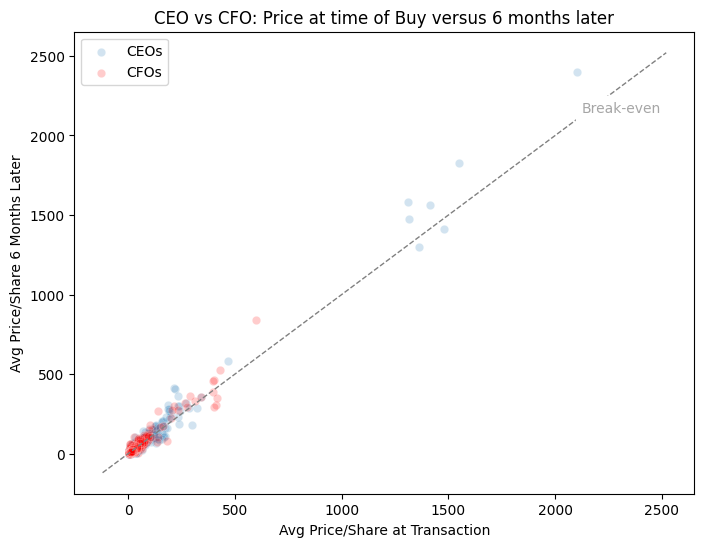

In [44]:
#Let's Look at CEO's vs CFO's
plt.figure(figsize=(8,6))
sns.scatterplot(data=ceo_df, x = 'average_price_per_share', y = 'price_6month', alpha =0.2,label='CEOs')
sns.scatterplot(data=cfo_df, x = 'average_price_per_share',y='price_6month',alpha=0.2,color='red',label='CFOs')

#Let's put in a 45degree line to show break even
ax = plt.gca()
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),
    max(ax.get_xlim()[1], ax.get_ylim()[1])
]
plt.plot(lims, lims, linestyle='--', color='gray', linewidth=1)

#Lets give it an annotation
x_text = lims[0] + 0.85 * (lims[1] - lims[0])
y_text = x_text
plt.text(
    x_text, y_text,
    'Break-even',
    ha='left', va='bottom',
    fontsize=10,
    color='gray',
    backgroundcolor='white',
    alpha=0.7
)

plt.xlabel('Avg Price/Share at Transaction')
plt.ylabel('Avg Price/Share 6 Months Later')
plt.title('CEO vs CFO: Price at time of Buy versus 6 months later')
plt.show()

Let's zoom in on stocks where the price at time of transaction was below a certain price to see the majority of the stocks. We will make this a dynamic variable to be easily changeable.

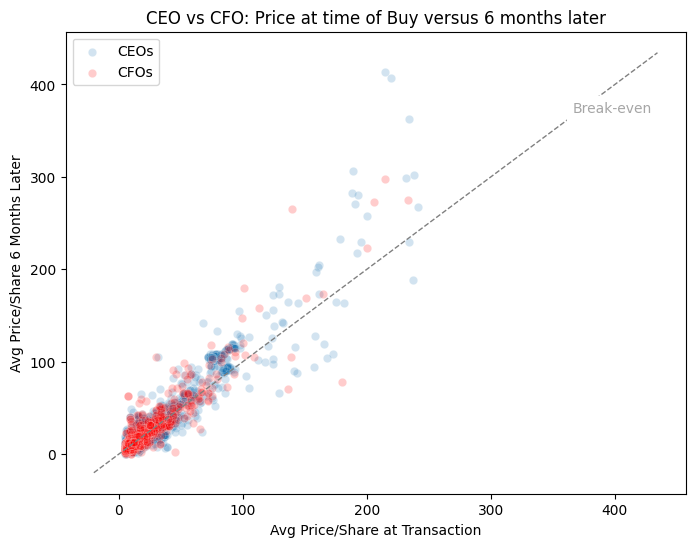

In [45]:
#price that we want zoom to
price = 250.00

#Let's Look at CEO's vs CFO's
ceo_df_small = ceo_df[ceo_df['average_price_per_share']<price]
cfo_df_small = cfo_df[cfo_df['average_price_per_share']<price]
plt.figure(figsize=(8,6))
sns.scatterplot(data=ceo_df_small, x = 'average_price_per_share', y = 'price_6month', alpha =0.2,label='CEOs')
sns.scatterplot(data=cfo_df_small, x = 'average_price_per_share',y='price_6month',alpha=0.2,color='red',label='CFOs')

#Let's put in a 45degree line to show break even
ax = plt.gca()
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),
    max(ax.get_xlim()[1], ax.get_ylim()[1])
]
plt.plot(lims, lims, linestyle='--', color='gray', linewidth=1)

#Lets give it an annotation
x_text = lims[0] + 0.85 * (lims[1] - lims[0])
y_text = x_text
plt.text(
    x_text, y_text,
    'Break-even',
    ha='left', va='bottom',
    fontsize=10,
    color='gray',
    backgroundcolor='white',
    alpha=0.7
)

plt.xlabel('Avg Price/Share at Transaction')
plt.ylabel('Avg Price/Share 6 Months Later')
plt.title('CEO vs CFO: Price at time of Buy versus 6 months later')
plt.show()

Finally, Let's demonstrate how we can create groups. Let's look at how well CEO's and CFO's do compared to EVP's and SVP's.

In [46]:
executives_df = complete_df[(complete_df['CFO']==1)|(complete_df['CEO']==1)]
vp_df = complete_df[(complete_df['EVP']==1)|(complete_df['SVP']==1)]
print(f"We have {executives_df.shape[0]} Executives")
print(f"We have {vp_df.shape[0]} VP's")
executives_df.head()

We have 4226 Executives
We have 1336 VP's


,Insider Name,Insider Title,Insider Role,Issuer,Ticker,CIK Code,Period of Report,Transaction Date,Security,Transaction Code,...,SLO,SMD,SVP,SVPi,See Remarks,T,TBE,VC,VP,VPf
155,ABRAM PETER,"CFO,SVP",Officer,FARO TECHNOLOGIES INC,FARO,917491,2014-05-28,2014-05-28,Common Stock,P,...,0,0,1,0,0,0,0,0,0,0
230,ACKERMAN JEFFREY C,"CFO,EVP",Officer,UNIFI INC,UFI,100726,2018-11-08,2018-11-08,Common Stock,P,...,0,0,0,0,0,0,0,0,0,0
241,ACKERMAN SAMUEL K,"CEO,P","Director,Officer","PANACOS PHARMACEUTICALS, INC.",PANC,1040017,2006-05-05,2006-05-05,Common Stock,P,...,0,0,0,0,0,0,0,0,0,0
509,ADAMS TIMOTHY M,CFO,Officer,"Rapid7, Inc.",RPD,1560327,2022-12-05,2022-12-05,COMMON STOCK,P,...,0,0,0,0,0,0,0,0,0,0
510,ADAMS TIMOTHY M,CFO,Officer,"Rapid7, Inc.",RPD,1560327,2022-05-09,2022-05-09,COMMON STOCK,P,...,0,0,0,0,0,0,0,0,0,0


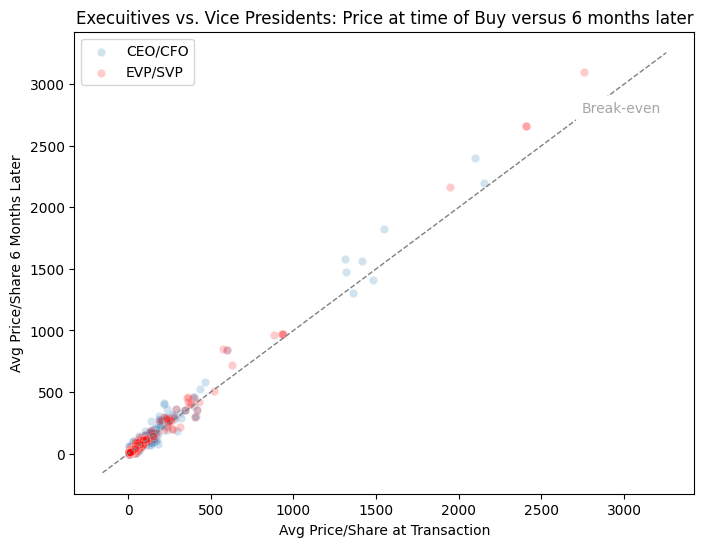

In [47]:
#Let's Look at CEO's vs CFO's
plt.figure(figsize=(8,6))
sns.scatterplot(data=executives_df, x = 'average_price_per_share', y = 'price_6month', alpha =0.2,label='CEO/CFO')
sns.scatterplot(data=vp_df, x = 'average_price_per_share',y='price_6month',alpha=0.2,color='red',label='EVP/SVP')

#Let's put in a 45degree line to show break even
ax = plt.gca()
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),
    max(ax.get_xlim()[1], ax.get_ylim()[1])
]
plt.plot(lims, lims, linestyle='--', color='gray', linewidth=1)

#Lets give it an annotation
x_text = lims[0] + 0.85 * (lims[1] - lims[0])
y_text = x_text
plt.text(
    x_text, y_text,
    'Break-even',
    ha='left', va='bottom',
    fontsize=10,
    color='gray',
    backgroundcolor='white',
    alpha=0.7
)

plt.xlabel('Avg Price/Share at Transaction')
plt.ylabel('Avg Price/Share 6 Months Later')
plt.title('Execuitives vs. Vice Presidents: Price at time of Buy versus 6 months later')
plt.show()

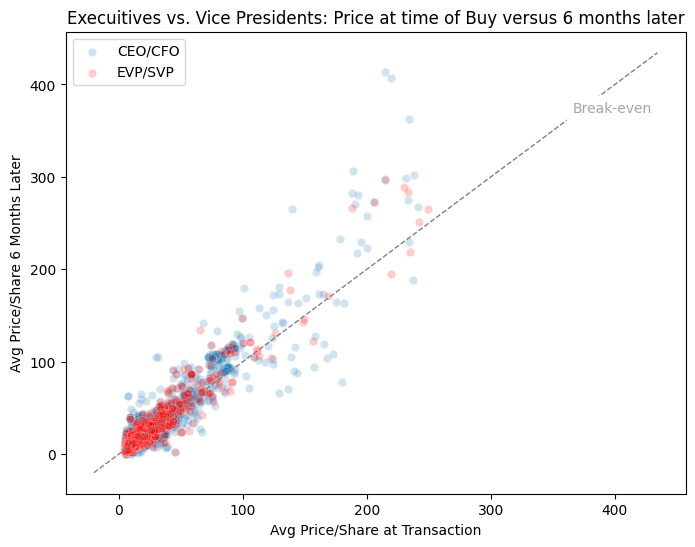

In [48]:
#Price we want to zoom in on
price = 250.00

exec_df_small = executives_df[executives_df['average_price_per_share']<price]
vp_df_small = vp_df[vp_df['average_price_per_share']<price]
#Let's Look at CEO's vs CFO's
plt.figure(figsize=(8,6))
sns.scatterplot(data=exec_df_small, x = 'average_price_per_share', y = 'price_6month', alpha =0.2,label='CEO/CFO')
sns.scatterplot(data=vp_df_small, x = 'average_price_per_share',y='price_6month',alpha=0.2,color='red',label='EVP/SVP')

#Let's put in a 45degree line to show break even
ax = plt.gca()
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),
    max(ax.get_xlim()[1], ax.get_ylim()[1])
]
plt.plot(lims, lims, linestyle='--', color='gray', linewidth=1)

#Lets give it an annotation
x_text = lims[0] + 0.85 * (lims[1] - lims[0])
y_text = x_text
plt.text(
    x_text, y_text,
    'Break-even',
    ha='left', va='bottom',
    fontsize=10,
    color='gray',
    backgroundcolor='white',
    alpha=0.7
)

plt.xlabel('Avg Price/Share at Transaction')
plt.ylabel('Avg Price/Share 6 Months Later')
plt.title('Execuitives vs. Vice Presidents: Price at time of Buy versus 6 months later')
plt.show()

# Looking at returns with comparison to the Benchmark
So far we have only been looking at whether or not the insider has been making money after six months. However, it should be a little more nuanced than this. For example, if it is a down market during that six months, a profitable trade may be considered one that didn't loose as much as the general market. One way we can do this is by finding the Excess (relative return) also known as alpha. We can do this by finding the
$$ \alpha = STOCK_{RETURN}-SPY_{RETURN}$$
This will give us an idea of whether or not the stock trade out- or under-performed compared to the market. This may give us a cleaner separation of our groups... Or it may not, we will see.

In [49]:
#We need to start by calculating the Returns
columns = complete_df.columns
#for column in columns:
#    print(column)
#Let's start by finding six month stock returns
complete_df['stock_return_6mos'] = (complete_df['price_6month']-complete_df['average_price_per_share'])/complete_df['average_price_per_share']
#Let's calculate the spy stock returns
complete_df['spy_return_6mos']=(complete_df['spy_price_6month']-complete_df['spy_price_transactiondate'])/complete_df['spy_price_transactiondate']

#Let's calculate our alpha
complete_df['alpha_6mos_%'] = np.round((complete_df['stock_return_6mos']-complete_df['spy_return_6mos'])*100,2)

#Let's take a quick look at these to make sure the calculations add up
complete_df[['average_price_per_share',
             'price_6month',
             'stock_return_6mos',
             'spy_price_transactiondate',
             'spy_price_6month',
             'spy_return_6mos',
             'alpha_6mos_%']].sample(5)


,average_price_per_share,price_6month,stock_return_6mos,spy_price_transactiondate,spy_price_6month,spy_return_6mos,alpha_6mos_%
51977,30.01,24.14,-0.195601,104.87,113.03,0.077811,-27.34
25102,35.07,41.84,0.193042,275.00,325.30,0.182909,1.01
54473,9.80,11.50,0.173469,349.02,398.63,0.142141,3.13
61944,36.17,40.87,0.129942,504.84,558.39,0.106073,2.39
48028,68.27,69.10,0.012158,535.29,570.99,0.066693,-5.45


Now that we have been able to calculate all of these, let's visually inspect some of the data. First, let's look at the distribution of SPY returns and then we can plot the distribution of returns based on specific positions.

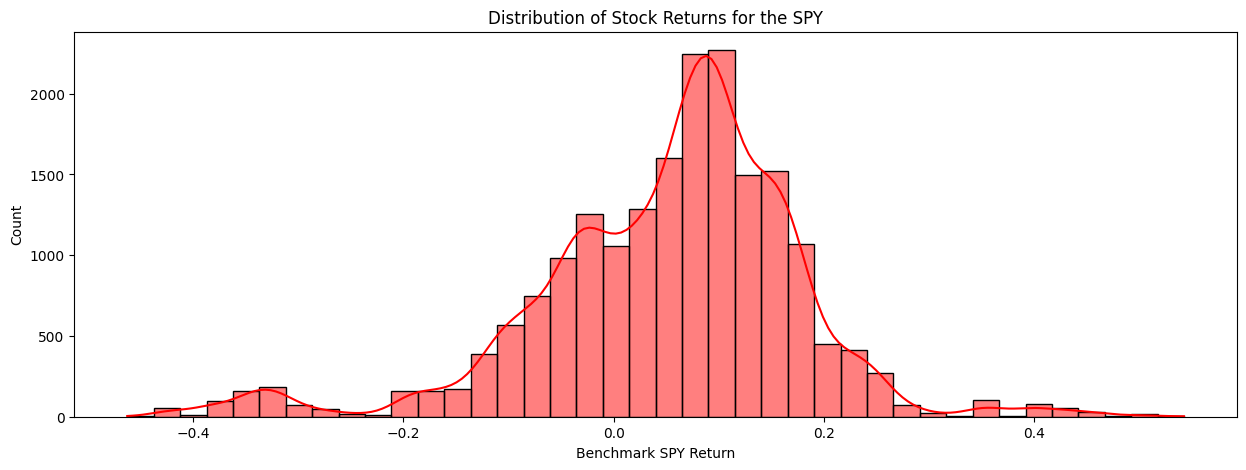

In [50]:
#Let's create a visualizations to look at the stock return distribution
plt.figure(figsize=(15,5))
sns.histplot(complete_df['spy_return_6mos'],kde=True, color='red',bins=40)
plt.title(f"Distribution of Stock Returns for the SPY")
plt.xlabel('Benchmark SPY Return')
plt.ylabel('Count')
plt.show()

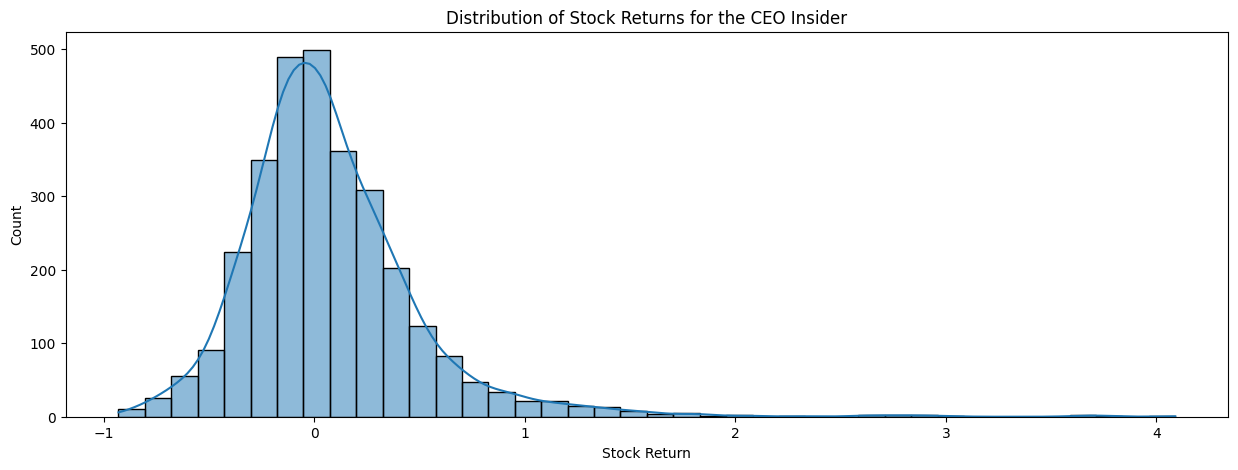

In [51]:
#Let's pick the postion that we want to look at return distribution for
position = 'CEO'

#Let's filter the dataframe for that position
position_df = complete_df[complete_df[position]==1]

#Let's create a visualizations to look at the stock return distribution
plt.figure(figsize=(15,5))
sns.histplot(position_df['stock_return_6mos'],kde=True,bins=40)
plt.title(f"Distribution of Stock Returns for the {position} Insider")
plt.xlabel('Stock Return')
plt.ylabel('Count')
plt.show()


We can see a pretty heavily right skewed distribution. This may mean that we need to check for normality prior to our hypothesis testing.

One of the first things we can look at is the distribution of all insider tranactions versus that of benchmark. Do insiders show better returns?


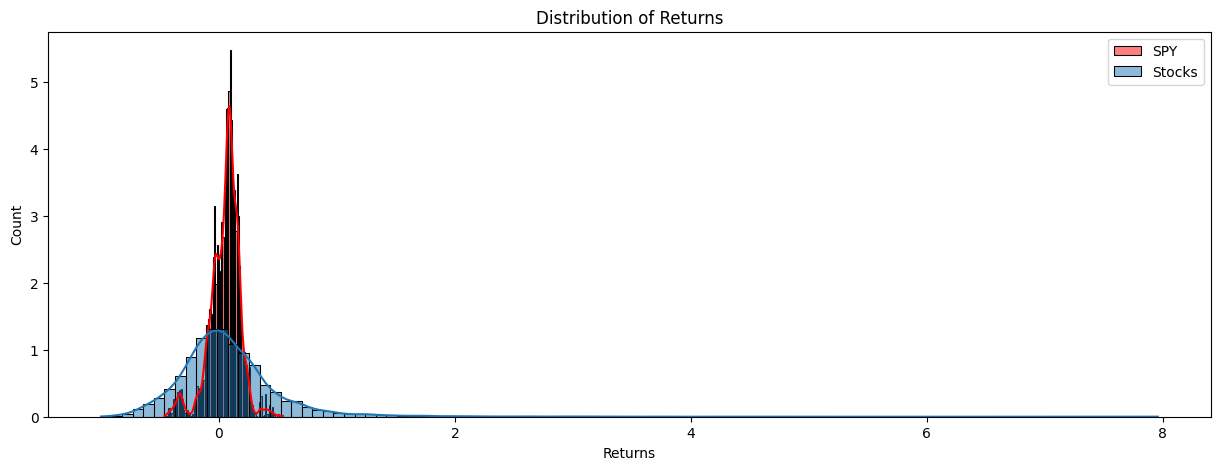

In [52]:
#Let's create a visualizations to look at the stock return distribution
plt.figure(figsize=(15,5))
sns.histplot(complete_df['spy_return_6mos'],kde=True, color='red',bins=100,stat='density',label='SPY')
sns.histplot(complete_df['stock_return_6mos'],kde=True,bins=100,stat='density',label='Stocks')
plt.legend()
plt.title(f"Distribution of Returns")
plt.xlabel('Returns')
plt.ylabel('Count')
plt.show()

So, it looks like the mean return for insiders is lower than that of the Benchmark, however there is a lot more variation. Our goal will be to now see if that variation is due to the role the insider plays in the company? Do CFOs and CAOs have a higher mean return then say Secretaries and Vice Presidents?

It would be interesting to see what are the top 10 to 20 positions that we have in our dataset. So let's grab all of the position columns, sum them (because they are one hot encoded) and see which has the highest value.

In [53]:
#Let's take all of the columns
columns = complete_df.columns
#Let's slice it to only contain the titles
positions = columns[67:-3]
#Now, let's sum those columns
sums = complete_df[positions].sum(axis=0)
top11 = sums.nlargest(11)
#Let's take a look at the top positions, I'm taking the top 11 because the first one is 'Missing', which means a director or 10% owner likely.
print(top11)

Missing     13197
Director    12987
Officer      6859
10%owner     5871
CEO          3143
P            1984
CFO          1087
EVP           845
C             545
SVP           491
COO           458
dtype: int64


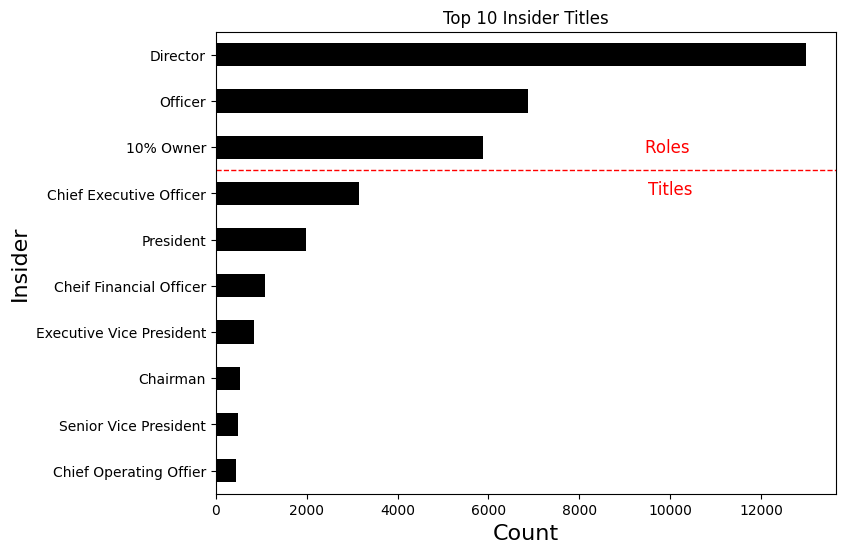

In [54]:
top10=top11[1:].copy()
#Let's write out the full title name for our plot
custom_labels = ['Director',
                 'Officer',
                 '10% Owner',
                 'Chief Executive Officer',
                 'President',
                 'Cheif Financial Officer',
                 'Executive Vice President',
                 'Chairman',
                 'Senior Vice President',
                 'Chief Operating Offier']

plt.figure(figsize=(8,6))
ax = top10.plot(kind='barh', color='black')

#Let's add a dashed line to seperate the roles and titles
sep_index = 3
#Needs to be inbetween the indices
sep_y = sep_index - 0.5

ax.axhline(
    y=sep_y,
    xmin=0,
    xmax=1,
    color='red',
    linestyle='--',
    linewidth=1
)
# Let's also add some text
x_text = 10000
ax.text(
    x_text,
    sep_y+0.6,
    'Roles \n\nTitles',
    ha='center',
    va='bottom',
    color='red',
    fontsize=12)

ax.set_xlabel('Count',fontsize=16)
ax.set_ylabel('Insider',fontsize=16)
ax.set_yticks(range(len(top11)-1))
ax.set_yticklabels(custom_labels)
ax.set_title('Top 10 Insider Titles')
plt.gca().invert_yaxis() #Have the largest at the top
plt.show()

Let's plot stock return versus the spy return for different postions. Let's start by looking at CEO's vs. Presidents. Here we will include a price and positions variables for filtering the visualizations easily instead of repeating code.

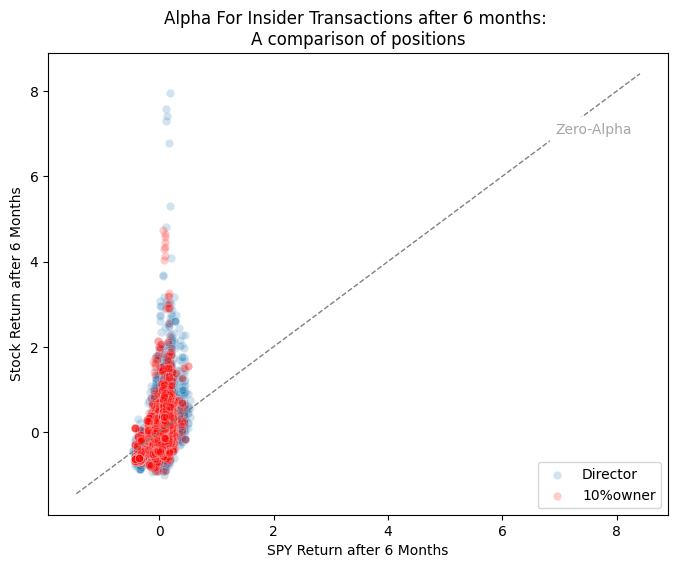

In [55]:
#Price we want to zoom in on
price = 10000
#Position we Want
position1 = 'Director'
position2 = '10%owner'


position1_df = complete_df[(complete_df[position1] == 1) &
                           (complete_df['average_price_per_share']<price)]
position2_df = complete_df[(complete_df[position2]==1) &
                            (complete_df['average_price_per_share']<price)]
#Let's Look at CEO's vs CFO's
plt.figure(figsize=(8,6))
sns.scatterplot(data=position1_df, x = 'spy_return_6mos', y = 'stock_return_6mos', alpha =0.2,label=position1)
sns.scatterplot(data=position2_df, x = 'spy_return_6mos',y='stock_return_6mos',alpha=0.2,color='red',label=position2)

#Let's put in a 45degree line to show break even
ax = plt.gca()
lims = [
    min(ax.get_xlim()[0], ax.get_ylim()[0]),
    max(ax.get_xlim()[1], ax.get_ylim()[1])
]
plt.plot(lims, lims, linestyle='--', color='gray', linewidth=1)

#Lets give it an annotation
x_text = lims[0] + 0.85 * (lims[1] - lims[0])
y_text = x_text
plt.text(
    x_text, y_text,
    'Zero-Alpha',
    ha='left', va='bottom',
    fontsize=10,
    color='gray',
    backgroundcolor='white',
    alpha=0.7
)
plt.legend(loc='lower right')
plt.xlabel('SPY Return after 6 Months')
plt.ylabel('Stock Return after 6 Months')
plt.title('Alpha For Insider Transactions after 6 months: \nA comparison of positions')
plt.show()

Now, we can also look at the distributions between insider positions.

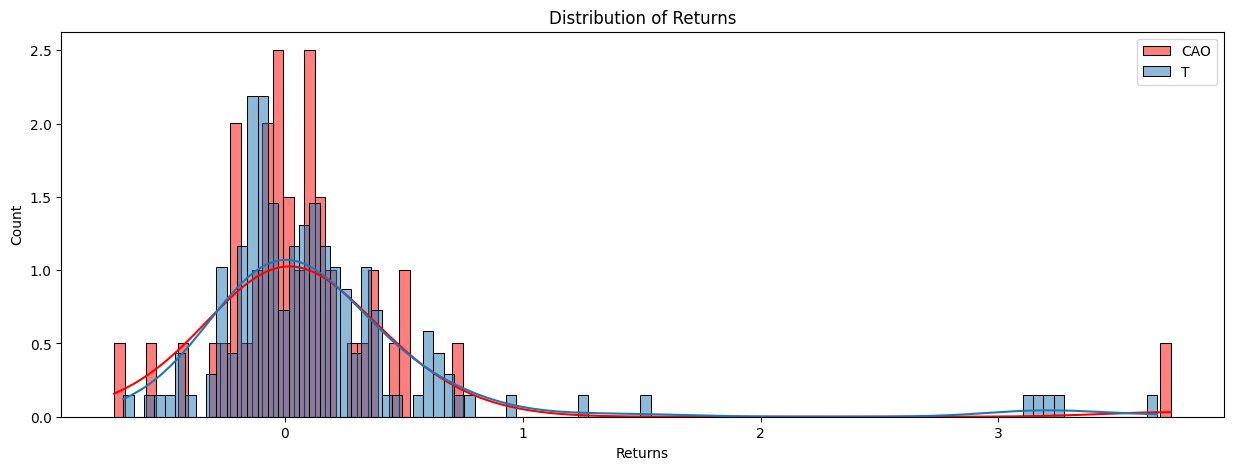

In [88]:
#Let's pick the positions we want to compare
position1 = 'CAO'
position2 = 'T'

#Let's create a visualizations to look at the stock return distribution
plt.figure(figsize=(15,5))
sns.histplot(complete_df[complete_df[position1]==1]['stock_return_6mos'],kde=True, color='red',bins=100,stat='density',label=position1)
sns.histplot(complete_df[complete_df[position2]==1]['stock_return_6mos'],kde=True,bins=100,stat='density',label=position2)
plt.legend()


plt.title(f"Distribution of Returns")
plt.xlabel('Returns')
#If we want to simulate a log scale uncomment the following line
#plt.xscale('symlog',linthresh=0.01)
plt.ylabel('Count')
plt.show()

This is not looking very promising for any form of signifcantly signifcant alpha found through tracking insider trades. With the heavily skewed data it may be a good idea to use a log scale. First, let's check and see if the data is considered normally distributed because the skew has such small values. We can use scipy.stats

In [57]:
from scipy.stats import shapiro,probplot
position = 'S'
data = complete_df[complete_df[position]==1]['stock_return_6mos']

#We are getting a nan value, this may mean there is bad data
nonfinite = data[~np.isfinite(data)]
#print(nonfinite)

#Turns out there is a ton of values where we don't have data six months later so let's drop those.
complete_df = complete_df[~complete_df['price_6month'].isna()].copy()
data = complete_df[complete_df[position]==1]['stock_return_6mos']

#Test with a Shapiro-Wilk Tests
stat, p_normal = shapiro(data)
#print(p_normal)

if p_normal > 0.05:
    print(f"The data for {position} insiders is normally distributed and a t-test can be used for hypothesis testing")
else:
    print(f"The data for {position} insiders is not normally distributed")

The data for S insiders is not normally distributed


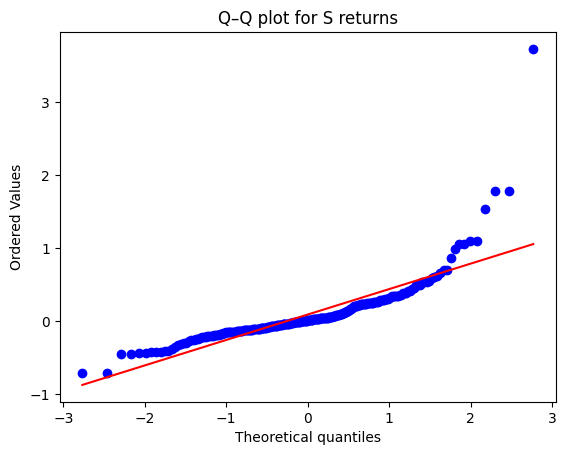

In [58]:
probplot(data, dist="norm", plot=plt)
plt.title(f"Q–Q plot for {position} returns")
plt.show()

Once again, this shows a heavily right skewed array for most of the positions. We can potentially use a log transformation to bring the data closer to a normal distribution. However, because we are using returns with negative values we need to shift all values to be positive.

In [59]:
#Let's shift all of the data to positive values
shifted = abs(data.min()) + 1e6
transformed = np.log(data + shifted)

#Rerun rest with a Shapiro-Wilk Tests
stat, p_normal = shapiro(transformed)
print(p_normal)

if p_normal > 0.05:
    print(f"The data for {position} insiders is normally distributed and a t-test can be used for hypothesis testing")
else:
    print(f"The data for {position} insiders is not normally distributed")

7.019272760030381e-20
The data for S insiders is not normally distributed


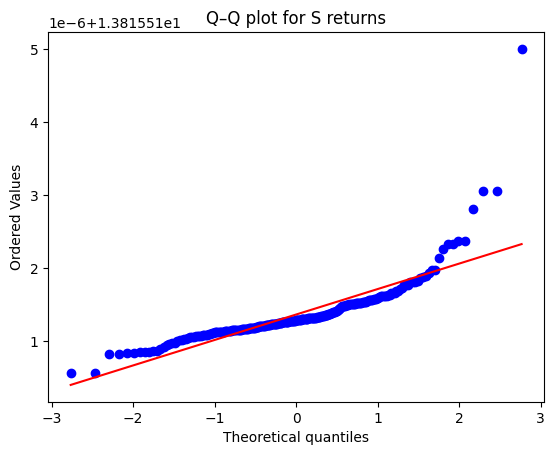

In [60]:
probplot(transformed, dist="norm", plot=plt)
plt.title(f"Q–Q plot for {position} returns")
plt.show()

Even with the transfomrations we are not finding normality, and we don't want to force it so it is probably better to use a nonparametric test like the Mann-Whitney.

In [61]:
from scipy.stats import mannwhitneyu

position1 = 'CEO'
position2 = 'CFO'

#Let's get our arrays
pos1_data = complete_df[complete_df[position1]==1]['stock_return_6mos']
pos2_data = complete_df[complete_df[position2]==1]['stock_return_6mos']

#Let's run our hypothesis test
ustat,p_val = mannwhitneyu(pos1_data,pos2_data,alternative='two-sided')
print(f"P-Value: {np.round(p_val,4)}")
if p_val > 0.5:
    print(f"There is not a significant difference between {position1} & {position2} insiders")
else:
    print(f"There is a significant difference between {position1} & {position2} insiders")

P-Value: 0.8724
There is not a significant difference between CEO & CFO insiders


Not surprisingly, we have no signifcant difference between insiders but let's look at whether there is a difference from a group compared to the benchmark spy to see if following the insiders gives us an advantage

In [91]:
from scipy.stats import mannwhitneyu

position = 'Director'

#Let's get our arrays
pos1_data = complete_df[complete_df[position]==1]['stock_return_6mos']
pos2_data = complete_df[complete_df[position]==1]['spy_return_6mos']

#Let's run our hypothesis test
ustat,p_val = mannwhitneyu(pos1_data,pos2_data,alternative='two-sided')
print(f"Mann Whitney P-Value: {p_val}")
if p_val > 0.05:
    print(f"There is not a significant difference between {position} insiders & the SPY")
else:
    print(f"There is a significant difference between {position} insiders & the SPY")

Mann Whitney P-Value: 3.241604874532611e-43
There is a significant difference between Director insiders & the SPY


This doesn't seem right, I have found a significant difference here but looking at the data there shouldnt be one. Let's inspect it visually and see if anything stands out so that we can address this. Two things to note, the spy and stock returns are for the same time periods so they are paired samples. So we should probably use the Wilcoxon signed-rank test.

First, we can look at how big the gap is between the two. A good way to quantify the effect size is Cliff's delta. which ranges from -1 to +1.

In [93]:
def cliffs_delta(x, y):
    # +1 for every x>y, -1 for every x<y
    diffs = np.subtract.outer(x, y)
    more = np.sum(diffs > 0)
    less = np.sum(diffs < 0)
    n1, n2 = len(x), len(y)
    return (more - less) / (n1 * n2)

delta = cliffs_delta(pos1_data.values, pos2_data.values)
print(f"Cliff's delta: {delta:.3f}")

Cliff's delta: -0.101


With a -0.1 we are seing that insiders often underperform compared to the SPY. However, it is a relatively small effect. When we run a paired non-parametric test

In [92]:
from scipy.stats import wilcoxon

stat, p_paired = wilcoxon(pos1_data, pos2_data)
print(f"Wilcoxon p-value: {p_paired:.2e}")

if p_val > 0.05:
    print(f"There is not a significant difference between {position} insiders & the SPY")
else:
    print(f"There is a significant difference between {position} insiders & the SPY")

Wilcoxon p-value: 1.18e-20
There is a significant difference between Director insiders & the SPY


We find that we still have a significant difference. Now, because this is non-parametric, it is essentially comparing the rank or central tendency (median) more so the the mean, so let's plot that to visually see it

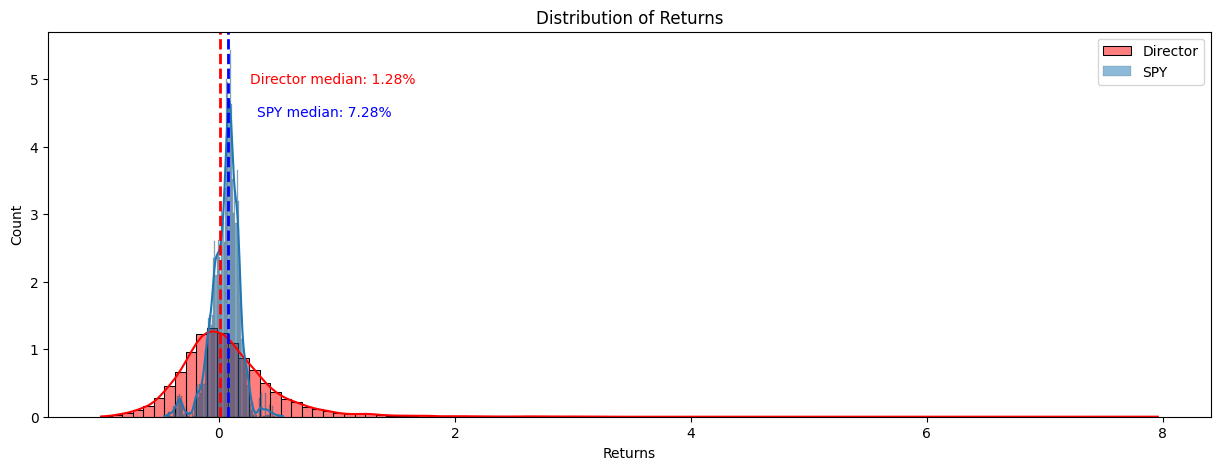

In [107]:
position = 'Director'
#Let's create a visualizations to look at the stock return distribution
plt.figure(figsize=(15,5))

#Let's calculate the mean for each so that we can plot it
med_stock = complete_df[complete_df[position]==1]['stock_return_6mos'].median()
med_spy = complete_df[complete_df[position]==1]['spy_return_6mos'].median()

#Let's plot the histogram and density curves
sns.histplot(complete_df[complete_df[position]==1]['stock_return_6mos'],kde=True, color='red',bins=100,stat='density',label=position)
sns.histplot(complete_df[complete_df[position]==1]['spy_return_6mos'],kde=True,bins=100,stat='density',label='SPY')

#Let's pot a vertical line at each mean
plt.axvline(med_stock, color='red',linestyle='--',linewidth=2)
plt.axvline(med_spy, color='blue',linestyle='--',linewidth=2)

#Let's annotate the values
plt.text(med_stock+0.25, 5,
    f"{position} median: {np.round(med_stock*100,2)}%",
    color='red', va='center', ha='left', fontsize=10)

plt.text(med_spy+0.25, 4.5,
    f"SPY median: {np.round(med_spy*100,2)}%",
    color='blue', va='center', ha='left', fontsize=10)


#Let's plot the legend and titles
plt.legend()
plt.title(f"Distribution of Returns")
plt.xlabel('Returns')
#If we want to simulate a log scale uncomment the following line
#plt.xscale('symlog',linthresh=0.01)
plt.ylabel('Count')
plt.show()

Here, it is looking like the insiders beat the benchmark when taking the mean, however, when we look at the median, they consistently under perform the market. This is an important distinction when we are looking at how to present the results. The mean is affected by the outliers of 800% returns etc.

Now that we have looked at insiders versus the benchmark, we can futher investigate whether the relative returns are better for specific insiders (i.e. SVP versus VP)

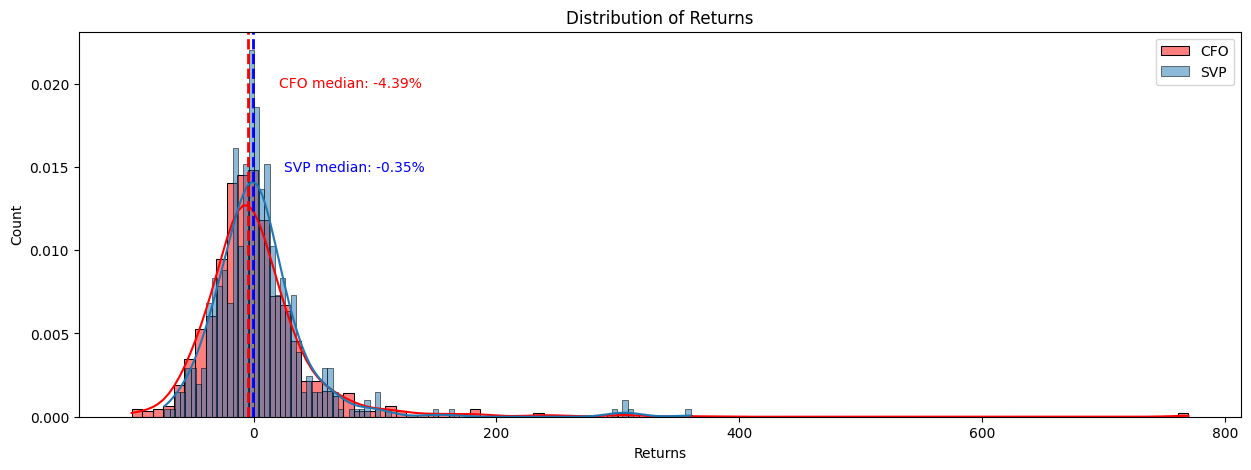

In [113]:
position1 = 'CFO'
position2 = 'SVP'

#Let's create a visualizations to look at the stock return distribution
plt.figure(figsize=(15,5))

#Let's calculate the mean for each so that we can plot it
med_pos1 = complete_df[complete_df[position1]==1]['alpha_6mos_%'].median()
med_pos2 = complete_df[complete_df[position2]==1]['alpha_6mos_%'].median()

#Let's plot the histogram and density curves
sns.histplot(complete_df[complete_df[position1]==1]['alpha_6mos_%'],kde=True, color='red',bins=100,stat='density',label=position1)
sns.histplot(complete_df[complete_df[position2]==1]['alpha_6mos_%'],kde=True,bins=100,stat='density',label=position2)

#Let's pot a vertical line at each mean
plt.axvline(med_pos1, color='red',linestyle='--',linewidth=2)
plt.axvline(med_pos2, color='blue',linestyle='--',linewidth=2)

#Let's annotate the values
plt.text(med_pos1+25, .02,
    f"{position1} median: {np.round(med_pos1,2)}%",
    color='red', va='center', ha='left', fontsize=10)

plt.text(med_pos2+25, .015,
    f"{position2} median: {np.round(med_pos2,2)}%",
    color='blue', va='center', ha='left', fontsize=10)


#Let's plot the legend and titles
plt.legend()
plt.title(f"Distribution of Returns")
plt.xlabel('Returns')
#If we want to simulate a log scale uncomment the following line
#plt.xscale('symlog',linthresh=0.01)
plt.ylabel('Count')
plt.show()